# Import Libraries

In [2]:
import sys
import mne
import scipy.io as sp
from scipy import interpolate
import numpy as np
import random
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import concurrent.futures
from mne.decoding import CSP
import pymrmr
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC as SVM
from sklearn.ensemble import ExtraTreesClassifier as ET
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import logging
from scipy.io import loadmat
from scipy.signal import hamming
from scipy.signal import hann
from scipy.signal import blackman
from scipy.signal import kaiser
from scipy.signal import gaussian
from sklearn.decomposition import FastICA
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
import os
import pickle
import multiprocessing
from sklearn.model_selection import GridSearchCV
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Circle
from matplotlib.font_manager import FontProperties
from scipy.stats import friedmanchisquare
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
import scikit_posthocs as sp
import pingouin as pg



/home/mahdi146/jupyter2/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Initialization

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
np.set_printoptions(threshold=np.inf)

In [4]:
WINDOW_TIME_LENGTH = 4
SAMPLING_RATE = 250
NUMBER_OF_CHANNELS = 64
beta = 1.5
SAMPLING_FREQ = 250


epoch_length = 1000
sampling_freq = 250
number_of_runs = 10
number_of_components = 10
number_of_selected_features = 10
number_of_processes = 10
number_of_bands = 9
column_names = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block']
column_names_v2 = ['participant', 'class1', 'class2','running_time','test_acc','train_acc','test_size','train_size','train_block','test_block','test_acc_vote']
green_bundle = np.arange(0,32)
yellow_bundle = np.arange(32,64)
MC_bundle  = [5,6,7,8,9,10,11,12,21,22,23,24,25,26,27,28,29,38,39,40,41,42,43,53,54,55,56,57,58,59,64]
#indexing starts at 0
MC_bundle = [x-1 for x in MC_bundle]

trial_order=[['Tongue','Feet','Mis','Hand'],
            ['Feet','Mis','Hand','Tongue'],
            ['Hand','Feet','Tongue','Mis'],
            ['Tongue','Mis','Hand','Feet'],
            ['Mis','Feet','Hand','Tongue'],
            ['Feet','Hand','Tongue','Mis'],
            ['Hand','Tongue','Mis','Feet'],
            ['Tongue','Feet','Mis','Hand'],
            ['Mis','Tongue','Hand','Feet']]


# Functions

In [5]:
def get_task_rest_times(b_num):
    if b_num == 0:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 1:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]
        
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]
        
    elif b_num == 2:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    elif b_num == 3:
        task_time = [[12, 16, 20, 8],
                    [16, 12, 20, 8],
                    [20, 16, 8, 12],
                    [20, 12, 8, 16]]
        
        rest_time = [[20, 8, 16, 12],
                    [16, 20, 8, 12],
                    [12, 20, 16, 8],
                    [20, 12, 8, 16]]
        
    elif b_num == 4:
        task_time = [[16, 8, 20, 12],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16],
                    [8, 20, 12, 16]]
        
        rest_time = [[8, 12, 16, 20],
                    [16, 20, 12, 8],
                    [12, 16, 8, 20],
                    [20, 8, 12, 16]]
        
    elif b_num == 5:
        task_time = [[16, 12, 8, 20],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12],
                    [12, 8, 16, 20]]

        rest_time = [[12, 8, 16, 20],
                    [16, 8, 20, 12],
                    [20, 12, 16, 8],
                    [8, 16, 12, 20]]
        
    elif b_num == 6:
        task_time = [[16, 8, 12, 20],
                    [20, 8, 16, 12],
                    [8, 16, 12, 20],
                    [16, 20, 12, 8]]

        rest_time = [[16, 8, 12, 20],
                    [12, 20, 8, 16],
                    [20, 16, 12, 8],
                    [8, 16, 20, 12]]     
    elif b_num ==7:
        task_time = [[12, 8, 20, 16],
                    [16, 20, 8, 12],
                    [8, 20, 16, 12],
                    [8, 12, 20, 16]]   
               
        rest_time = [[16, 12, 8, 20],
                    [8, 20, 12, 16],
                    [20, 16, 8, 12],
                    [12, 16, 20, 8]]  
    
    elif b_num == 8:
        task_time = [[16, 8, 12, 20],
                    [20, 16, 12, 8],
                    [12, 20, 8, 16],
                    [8, 12, 16, 20]]
        
        rest_time = [[8, 20, 16, 12],
                    [12, 8, 20, 16],
                    [16, 12, 20, 8],
                    [8, 12, 20, 16]]
        
    else:
        raise("Error in block number")
    

    return task_time,rest_time


In [6]:
def trial_times_genertor(task_times,rest_times):
    block_times = [item for pair in zip(task_times, rest_times) for item in pair]
    return block_times
    

In [7]:
def calc_csp(x_train, y_train, x_test,number_of_components):
    # csp = CSP(n_components=number_of_components, reg='ledoit_wolf', log=True)
    csp = CSP(number_of_components)


    csp_fit = csp.fit(x_train, y_train)
    train_feat = csp_fit.transform(x_train)
    test_feat = csp_fit.transform(x_test)
    return train_feat, test_feat

In [8]:
def feature_extractor(dataset, labels, number_of_bands, test_data,number_of_components):

    low_cutoff = 0
    
    for b in range(number_of_bands):
        logging.getLogger('mne').setLevel(logging.WARNING)
        low_cutoff += 4
        data = dataset.copy()
        data_test = test_data.copy() 
        # print(data.shape,data_test,"train test csp shape")
        # sys.exit()
        # print("Frequency range: ",low_cutoff)
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)
        filtered_data_test = mne.filter.filter_data(test_data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, n_jobs = 4)

        #PCA
        # from mne.decoding import UnsupervisedSpatialFilter
        # from sklearn.decomposition import PCA, FastICA

        # pca = UnsupervisedSpatialFilter(PCA(64), average=False)
        # pca_fit = pca.fit(filtered_data)
        # filtered_data = pca_fit.transform(filtered_data)
        # filtered_data_test = pca_fit.transform(filtered_data_test)
        # train_feats = filtered_data
        # test_feats = filtered_data_test

        # filtered_data = data
        # filtered_data_test = data_test
        
        [train_feats, test_feats] = calc_csp(filtered_data, labels[:,0], filtered_data_test,number_of_components)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
    
    return train_features, test_features

In [9]:
def feature_selector(train_features, labels, number_of_selected_features):
    X = pd.DataFrame(train_features)
    y = pd.DataFrame(labels)
    K = number_of_selected_features
    
    df = pd.concat([y,X], axis = 1)
    df.columns = df.columns.astype(str)
        
    selected_features = list(map(int, pymrmr.mRMR(df, 'MID', K)))
    return selected_features

In [10]:
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        data_dict[b_num] = df
    return data_dict


In [11]:
def get_group_start_indices(dataframe):
    group_indices = []
    current_label = None

    for idx, row in dataframe.iterrows():
        if row.iloc[-1] != current_label:
            group_indices.append(idx)
            current_label = row.iloc[-1]

    return group_indices

In [12]:
def extra_samples_block_counter(df,trial_order,b_num):

    df.drop(df[df.iloc[:,-1].isin(['Begin', 'End'])].index, inplace=True)
    df.reset_index(drop=True, inplace=True)    
    df['group'] = (df.iloc[:,-1] != df.iloc[:,-1].shift(1)).cumsum()

    
    group_counts_Rest = df[df.iloc[:,-1] == 'Rest'].groupby('group').size()
    with open('sampleList.txt', 'a') as file:
        file.write(f'block {b_num+1} '+'\n')
        for j in range (len(trial_order)):
            print(trial_order[j])
            trial_num = j
            task_times,rest_times = get_task_rest_times(b_num)
            trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
            trial_samples = [item*SAMPLING_RATE for item in trial_times]
            group_counts_task = df[df.iloc[:,-1] == trial_order[j]].groupby('group').size()
            sampleList = []
            for i in range(4):
                task = group_counts_task.iloc[i]
                rest = group_counts_Rest.iloc[4*j+i]
                sampleList.append(task)
                sampleList.append(rest)
            # extra_samples = [x-y for x,y in zip(sampleList,trial_samples)]
            file.write(', '.join(map(str, sampleList)) + f' trial={trial_order[j]} '+'\n')
            print(sampleList)
        file.write('\n\n')


In [13]:
def data_cleaner(df,class_1,class_2,tasks_time):
    class_x = class_1
    class_y = class_2
    new_df = pd.DataFrame()
    trial_df = df.copy() 
    for i in range(len(tasks_time)):
        sample_point = tasks_time[i]*SAMPLING_RATE
        if(trial_df.iloc[sample_point+1,-1] == class_x ):
            if(i==len(tasks_time)-1):
                temp_df = trial_df.iloc[:sample_point,:]
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
            else:    
                temp_df = trial_df.iloc[:sample_point,:]
                next_task_idx = trial_df[trial_df.iloc[:, -1] == class_y].index
                trial_df.drop(trial_df.index[0:next_task_idx[0]], inplace=True)
                trial_df.reset_index(drop=True, inplace=True)
                new_df = pd.concat([new_df, temp_df], axis=0)
                new_df.reset_index(drop=True, inplace=True)
                class_x,class_y = class_y,class_x

    return new_df

In [14]:
def shuffler(dataset,labels):
    print(dataset.shape)
    print(labels.shape)
    np.random.seed(42)
    indices = np.random.permutation(len(dataset))
    shuffled_dataset = dataset[indices]
    shuffled_labels = labels[indices]
    return shuffled_dataset,shuffled_labels
    

In [15]:
def cal_epoch(df_len,sliding_len,window_len):
    number_of_epochs = int((int(df_len-window_len)/sliding_len)) +1
    return number_of_epochs

In [16]:
def data_label_attacher(cleaned_df,class_1,class_2,random_flag,class_seperator_flag,sliding_time,window_time_length,window_type,number_of_channels):
    SLIDING_POINTS = int(sliding_time*SAMPLING_RATE)
    window_time = window_time_length
    WINDOW_SAMPLE_LENGTH = window_time*SAMPLING_RATE
    new_df_ = cleaned_df.copy()
    new_df_.drop(cleaned_df.columns[-1], axis=1, inplace=True)
    X = new_df_.to_numpy()
    X = np.transpose(X)
    number_of_epochs = cal_epoch(int(int(len(cleaned_df)/SAMPLING_RATE)),sliding_time,window_time)
    dataset = np.zeros((number_of_epochs,number_of_channels,WINDOW_SAMPLE_LENGTH))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    index = get_group_start_indices(cleaned_df)
    index.append(len(cleaned_df))
    k = 0  
    startIdx = int(k * WINDOW_SAMPLE_LENGTH)
    endIdx = int((k+1) * WINDOW_SAMPLE_LENGTH )
    l = 0
    label = 1
    for i in range(number_of_epochs):
        
        if(startIdx>=index[l] and endIdx<=index[l+1]):
            slice_X = X[:, startIdx:endIdx]

            if window_type.window_name == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,window_type.param_value)
                slice_X *= kaiser_window

            elif window_type.window_name == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type.window_name == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type.window_name == "Rec":
                pass

            else:
                raise ValueError("Window type is wrong!")

            dataset[i, :, :] = slice_X
            labels[i,0] = label

        else:
            
            temp = endIdx-index[l+1]
            # print(temp,endIdx,index[l+1],"temp,end,index l+1")
            slice_X = X[:, startIdx:endIdx]
            if window_type.window_name == "Kaiser":
                kaiser_window = kaiser(WINDOW_SAMPLE_LENGTH,window_type.param_value)
                slice_X *= kaiser_window

            elif window_type.window_name == "Hamming":
                hamming_window = hamming(WINDOW_SAMPLE_LENGTH)
                slice_X *= hamming_window
            
            elif window_type.window_name == "Hanning":
                hanning_window = hann(WINDOW_SAMPLE_LENGTH)
                slice_X *= hanning_window
            
            elif window_type.window_name == "Rec":
                pass
            
            else:
                raise ValueError("Window type is wrong!")
            dataset[i, :, :] = slice_X

            if(temp<WINDOW_SAMPLE_LENGTH/2):
                labels[i,0] = label
            else:
                labels[i,0] = int(not(label))

            if(startIdx>=index[l+1]):
                l+=1
                label = int(not(label))

                

        startIdx+=SLIDING_POINTS
        endIdx+=SLIDING_POINTS

    return dataset,labels




In [17]:
def trial_cutter(data, class_1):
    df = data.copy()
    Begin_trigger = "Begin" + "_" + class_1
    End_trigger = "End" + "_" + class_1
    Begin_idx = df[df.iloc[:, -1] == Begin_trigger].index
    End_idx = df[df.iloc[:, -1] == End_trigger].index
    trial_df = df.iloc[Begin_idx[0]+1:End_idx[0],:]
    trial_df.reset_index(drop=True, inplace=True)
    trial_df.head()
    return trial_df

In [18]:
def Begin_End_trigger_modifier(data):
    df = data.copy()
    Begin_indexes = df[df.iloc[:, -1] == 'Begin'].index
    End_indexes = df[df.iloc[:, -1] == 'End'].index
    if(len(Begin_indexes)==len(End_indexes)):
        for i in range(len(Begin_indexes)):
            index = Begin_indexes[i]+1
            val = df.iloc[index,-1]
            df.iloc[Begin_indexes[i],-1] = "Begin" + "_" + str(val)
            df.iloc[End_indexes[i],-1]   =  "End" + "_" + str(val)
    else:
        raise ValueError("Trigger seinding Exception")
    
    return df

In [19]:
def preprocessor(data_,class_1,class_2,tasks_time,set_type,clean_flag,sliding_time,window_time_length,window_type,number_of_channels):
    CLASS_1 = class_1
    CLASS_2 = class_2
    df = data_.copy()
    modified_df = Begin_End_trigger_modifier(df)
    trial_df = trial_cutter(modified_df,CLASS_1)
    indexes = get_group_start_indices(trial_df)

    if clean_flag:
        cleaned_df = data_cleaner(trial_df,CLASS_1,CLASS_2,tasks_time)
        final_df = cleaned_df.copy()
    else:
        final_df = trial_df.copy()

    if set_type =="TRAIN":
        random_flag = True
    elif set_type =="TEST":
        random_flag = False
    else:
        raise("Error in set type")

  
    final_data, final_labels = data_label_attacher(final_df,CLASS_1,CLASS_2,random_flag,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)
    
    return final_data,final_labels

In [20]:
def channel_remover(df, channels):
    df_copy = df.copy()
    df_copy.drop(df.columns[channels], axis=1, inplace=True)
    df_copy.columns = [np.arange(0,df_copy.shape[1])]
    return df_copy

In [21]:
def channel_keeper(df, channels_to_keep):

    df_copy = df.copy()
    # Drop columns that are not in channels_to_keep
    columns_to_drop = [col for col in df_copy.columns if col not in channels_to_keep]
    df_copy.drop(columns_to_drop, axis=1, inplace=True)
    df_copy.columns = [np.arange(0,df_copy.shape[1])]
    return df_copy

In [22]:
def trials_set_builder(data_dict,blocks_set,set_label,class_1,class_2,clean_flag,sliding_time,window_time_length,window_type,channels_to_keep,number_of_channels):
                                   
    counter = 0

    for b_num in blocks_set:
        trial_num = trial_order[b_num].index(class_1)
        task_times,rest_times = get_task_rest_times(b_num)
        trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])

        # data = remove_outliers_across_channels(data_dict[b_num],10)
        # data = remove_outliers(data_dict[b_num])
        data = data_dict[b_num]
        # data = apply_median_filter(data,9)
        # print(data.shape,"data shape")
        # sys.exit()

        # print(data.shape,"before removing")
        df = channel_keeper(data,channels_to_keep)
        number_of_channels = len(channels_to_keep)-1
        # print(df.shape,"after removing")
        # print(df.head(5))

        # if class_1== 'Tongue' or class_1 == 'Mis':
        #     data = channel_remover(data,channels_to_remove)
        #     number_of_channels =  NUMBER_OF_CHANNELS-len(channels_to_remove)
        # else:
        #     number_of_channels = NUMBER_OF_CHANNELS

        # df = data.copy()


        # last_column = df.pop(df.columns[-1])
        # df.drop(df.columns[-1], axis=1, inplace=True)
        # eeg_data = df.to_numpy().T  # Transpose to have channels in columns

        # channel_names = [f'Ch{i+1}' for i in range(63)]

        dataset,labels = preprocessor(df,class_1,class_2,trial_times,set_label,clean_flag,sliding_time,window_time_length,window_type,number_of_channels)

        if counter == 0 :
            final_data = dataset
            final_labels = labels
            # print("Before concatenation - final_data shape:", final_data.shape, "dataset shape:", dataset.shape)
        else:
            final_data = np.vstack((final_data, dataset))
            final_labels = np.vstack((final_labels, labels))
            print("After concatenation - final_data shape:", final_data.shape, "final_labels shape:", final_labels.shape)

        counter+=1 
    return final_data,final_labels

In [23]:
def find_duplicates(data_list):
    counted_values = Counter(data_list)
    duplicate_values = {value: count for value, count in counted_values.items() if count > 1}
    return duplicate_values

In [24]:
def Statistical_analysor(p_num_list,data_dicts_list,num_channels):

    with open('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Classification/Statistics.txt', 'w') as file:
        for p in range(len(p_num_list)):
            file.write(f'Particpant: {p+3} '+'\n')
            for b in range(7):
                file.write(f'Block: {b+1} '+'\n')
                data_pd = data_dicts_list[p][b]
                data = data_pd.iloc[:, :-1]
                data_np = data.values
                eeg_data = data_np
                print("Data type:", type(eeg_data))
                print("Shape:", eeg_data.shape)
                eeg_data = np.array(eeg_data)
                mean_values = np.mean(eeg_data, axis=0)
                variance_values = np.var(eeg_data, axis=0)
                std_deviation_values = []
                
                for i in range(num_channels):
                    print(f"Channel {i + 1}:")
                    print(f"Mean: {mean_values[i]}")
                    print(f"Variance: {variance_values[i]}")
                    std_deviation_values.append(np.sqrt(variance_values[i]))
                    print(f"Standard Deviation: {std_deviation_values[i]}")
                    print()
                    file.write(f'Channel {i+1}: '+'\n')
                    file.write(f"Mean: {mean_values[i]}"+"\n")
                    file.write(f"Variance: {variance_values[i]}"+"\n")
                    file.write(f"Standard Deviation: {std_deviation_values[i]}"+"\n\n")
                
                lists_to_check = {
                'mean_values': mean_values,
                'variance_values': variance_values,
                'std_deviation_values': std_deviation_values
                }
                for list_name, data_list in lists_to_check.items():
                    duplicate_values = find_duplicates(data_list)
                    if duplicate_values:
                        print(f"Duplicate values and their counts for {list_name}:")
                        file.write(f"Duplicate values and their counts for {list_name}:"+"\n")
                        for value, count in duplicate_values.items():
                            print(f"Value: {value}, Count: {count}")
                            file.write(f"Value: {value}, Count: {count}"+"\n")
                    else:
                        print(f"No duplicate values found in the {list_name} list.")
                        file.write(f"No duplicate values found in the {list_name} list."+"\n")


In [25]:
def custom_accuracy(y_true, y_pred):
    mismatches = []
    total = len(y_true)
    mismatch_count = 0
    
    for i, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        if true_label != pred_label:
            mismatches.append(i)
            mismatch_count += 1
            
    accuracy = 1 - (mismatch_count / total)
    
    return accuracy, mismatch_count, mismatches

In [26]:
def majority_vote_sliding_with_next(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list) - window_size + 1):
        window = prediction_list[i:i+window_size]
        window_tuple = tuple(window)
        counts = Counter(window_tuple)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes


In [27]:
def majority_vote_sliding_with_prev(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        if i >= window_size - 1:
            start_index = i - window_size + 1
            window = prediction_list[start_index:i+1]
            counts = Counter(window)
            majority = counts.most_common(1)[0][0]
            majority_votes.append(majority)
        
    return majority_votes

In [28]:
def majority_vote_sliding_with_prev_v2(prediction_list, window_size=3):
    majority_votes = []
    
    for i in range(len(prediction_list)):
        start_index = max(0, i - window_size + 1)
        window = prediction_list[start_index:i+1]
        counts = Counter(window)
        majority = counts.most_common(1)[0][0]
        majority_votes.append(majority)
        
    return majority_votes

In [29]:
def save_csv(new_row, path):
    absolute_path = os.path.abspath(path)

    # Create the directory if it doesn't exist
    directory = os.path.dirname(absolute_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(absolute_path, index=False)

In [30]:
def clean_csv(full_path):
    df = pd.read_csv(full_path)
    clean_df = pd.DataFrame(columns=df.columns)
    clean_df.to_csv(full_path, index=False)


In [31]:
def remove_csv(full_path):
    if os.path.exists(full_path):
        os.remove(full_path)
        print(f"File {full_path} has been removed.")
    else:
        raise(f"File {full_path} does not exist.")

In [32]:
def get_results_average(path,p_num_list,class_list):
    PATH = path
    vf = pd.DataFrame(columns=column_names_v2) 
    for p_num in p_num_list:
        print(p_num)
        rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
        vf = pd.concat([vf, rf], ignore_index=True)
    vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)

    columnNames = ['class','test_acc','vote_acc']
    kf = pd.DataFrame(columns=columnNames)
    kf.to_csv(PATH+'AverageAcc.csv',index=False)
    vf = pd.read_csv(PATH +"ResultsOfAll.csv")
    df = vf
    blk_list = [1234]
    for class_ in class_list:
        gf = df[(df['class1'] == class_)]
        avg_test = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean() 
        new_row = [class_, avg_test,avg_vote] 
        new_row_df = pd.DataFrame([new_row], columns=columnNames)
        rf = pd.read_csv(PATH + 'AverageAcc.csv')
        cf = pd.concat([rf, new_row_df], ignore_index=True)
        cf.to_csv(PATH +'AverageAcc.csv',index=False)  
    kf = pd.read_csv(PATH +'AverageAcc.csv') 
    print(kf.head())


In [33]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants/'
def pickle_reader(path, p_num, block_list):
    data_dict = {}
    
    for b_num in block_list:
        print(b_num)
        file_path = os.path.join(path, f"P{p_num}/P{p_num}B{b_num}.pkl")

        try:
            with open(file_path, 'rb') as file:
                data = pickle.load(file)

                data_dict[b_num] = data
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"Error loading data from {file_path}: {e}")

    return data_dict

In [34]:
def plot_feature_importance(feature_importances_, selected_features, figsize=(10, 6)):
    # Get feature importance scores
    feature_importance = feature_importances_

    # Create a DataFrame to display feature numbers and their importance scores
    feature_importance_df = pd.DataFrame({'Importance': feature_importance,'Feature Number': selected_features})
    
    # Sort features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    print(feature_importance_df,"f df")

    # Plot feature importance
    plt.figure(figsize=figsize)
    sns.barplot(x='Feature Number', y='Importance', data=feature_importance_df,order=feature_importance_df['Feature Number'])
    plt.title('XGBoost - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Number')
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Feature-Importance/Hand_XGB_10F_4Rec_100%.svg', format='svg')
 
    plt.show()
    return plt

In [35]:
def return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk_set):

    path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    f"{overlap_percent}%_Overlap",
    f"{window_time_length}_window_time_length",
    f"{window_type}_Window",
    f"{train_blk_set}_Train/"
    )

    data_dic = {path:pd.read_csv(path+"AverageAcc.csv")}
    acc = list(data_dic[path]['test_acc'])
    return acc


## Data Viz Functions

In [131]:
def print_statistics(df, columns_to_plot):
    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    medians = df[columns_to_plot].median()
    mins = df[columns_to_plot].min()
    maxs = df[columns_to_plot].max()

    for col, mean, std, median, min_val, max_val in zip(columns_to_plot, means, stds, medians, mins, maxs):
        print(f'Statistics for {col}:')
        print(f'Mean: {mean:.4f}')
        print(f'Standard Deviation: {std:.4f}')
        print(f'Median: {median:.4f}')
        print(f'Minimum: {min_val:.4f}')
        print(f'Maximum: {max_val:.4f}')
        print()  # Empty line for separation

def plot_box_chart(df, columns_to_plot, xlabels, target_chart, x_axis_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    xpos = np.arange(1, len(columns_to_plot) + 1)
    ax.boxplot(df[columns_to_plot].values, widths=0.2)
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(x_axis_name)
    ax.grid(True)
    ax.set_title(f'Box Plot of {target_chart}')
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v2/{target_chart}_BoxChart.svg', dpi=300)
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v2/{target_chart}_BoxChart.jpg', dpi=300)
    plt.show()

    print_statistics(df, columns_to_plot)

def plot_error_bar(df, columns_to_plot, xlabels, target_chart, x_axis_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    xpos = np.arange(1, len(columns_to_plot) + 1)
    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(x_axis_name)
    ax.grid(True)
    ax.set_title(f'Error Bars of {target_chart}')
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v2/{target_chart}_ErrorChart.svg', dpi=300)
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v2/{target_chart}_ErrorChart.jpg', dpi=300)
    plt.show()

    print_statistics(df, columns_to_plot)

def plot_box_error_combined(df, columns_to_plot, xlabels, target_chart, x_axis_name):
    fig, ax = plt.subplots(figsize=(6, 4))
    xpos = np.arange(1, len(columns_to_plot) + 1)
    ax.boxplot(df[columns_to_plot].values, widths=0.2)
    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    #ToDo: comment the below line
    stds = 0
    ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7, label='Average')
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(x_axis_name)
    ax.grid(True)
    ax.legend()
    # ax.set_title(f'Box Plot with Error Bars of {target_chart}')
    # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.svg', dpi=300)
    # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.jpg', dpi=300)
    plt.show()

    print_statistics(df, columns_to_plot)

def plot_box_error_combined_v2(df, columns_to_plot, xlabels, target_chart, x_axis_name,significance_matrix):

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.rcParams.update({'font.family': 'serif'})
    
    data = df[columns_to_plot].values
    xpos = np.arange(1, len(columns_to_plot) + 1)
    ax.boxplot(df[columns_to_plot].values, widths=0.2)

    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    # ToDo: comment the below line
    stds = 0
    ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', 
                marker='s', markersize=10, linewidth=2, label='Average')
    

    
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel(x_axis_name, fontsize=14)


    # ax.set_ylim([df[columns_to_plot].values.min() - 0.01, df[columns_to_plot].values.max() + 0.01])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # ax.set_title(f'Box Plot with Error Bars of {target_chart}', fontsize=16, pad=20)
    ax.legend(loc='upper left')

    y_offset = 0.02  # Starting offset for the lines above the boxplots
    cap_length = 0.004  # Length of the caps at the ends of the lines
    for i in range(len(columns_to_plot)):
        for j in range(i+1, len(columns_to_plot)):
            if significance_matrix[i][j] < 0.05:  # Significance level (e.g., 0.05)
                y = max(data[:, i].max(), data[:, j].max()) + y_offset  # Adjust line height for each pair
                # Draw the main horizontal line
                ax.plot([xpos[i], xpos[j]], [y, y], color='black', linewidth=1.5)
                # Add vertical caps to the ends of the line
                ax.plot([xpos[i], xpos[i]], [y - cap_length/2, y + cap_length/2], color='black', linewidth=1.5)
                ax.plot([xpos[j], xpos[j]], [y - cap_length/2, y + cap_length/2], color='black', linewidth=1.5)
                ax.text((xpos[i] + xpos[j]) / 2, y + 0.001, '*', ha='center', va='bottom', color='black', fontsize=14)
                y_offset += 0.02  # Increase the offset for the next line to avoid overlap


    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.jpg', dpi=600, bbox_inches='tight')
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.svg', dpi=600, bbox_inches='tight')
    
    plt.show()



def plot_box_error_combined_v3(df, columns_to_plot, xlabels, target_chart, x_axis_name):

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.rcParams.update({'font.family': 'serif'})

    xpos = np.arange(1, len(columns_to_plot) + 1)
    ax.boxplot(df[columns_to_plot].values, widths=0.2)

    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    # ToDo: comment the below line
    stds = 0
    ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', 
                marker='s', markersize=10, linewidth=2, label='Average')
    
    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel(x_axis_name, fontsize=14)


    ax.set_ylim([df[columns_to_plot].values.min() - 0.01, df[columns_to_plot].values.max() + 0.01])
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # ax.set_title(f'Box Plot with Error Bars of {target_chart}', fontsize=16, pad=20)
    ax.legend(loc='upper left')

    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.jpg', dpi=600, bbox_inches='tight')
    plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts-v3/{target_chart}_BoxErrorChart.svg', dpi=600, bbox_inches='tight')
    
    plt.show()



# Classes

In [37]:
class Window:
    def __init__(self,param_value,param_name,window_name):
        self.param_value = param_value
        self.param_name = param_name
        self.window_name = window_name


# Reading Data

In [223]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/Pickels_Participants'
# p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
p_num_list = [9]
block_list = [0,1,2,3,4,5,6]
data_dict_list = []
for p_num in p_num_list:
    print("Reading",p_num)
    data_dict = pickle_reader(path,p_num,block_list)
    data_dict_list.append(data_dict)

Reading 9
0
1
2
3
4
5
6


# Running Network

In [230]:
classifier_dic = {"SVM":SVM()}
number_of_components_list = [10]
# number_of_selected_features_list = [10,"All"]
number_of_selected_features_list = [10]

# number_of_selected_bands_list = [9]
# overlap_percent_list = [100,25]
channels_to_remove = []
number_of_channels = NUMBER_OF_CHANNELS
# window_time_length_list = [4,2,1]
window_time_length_list = [4]
vote_window = 3
# window_type_list_ = [Window(None,"Rec"),Window(1.5,"Kaiser"),Window(2,"Kaiser"),Window(2.5,"Kaiser"),Window(3,"Kaiser"),Window(3.5,"Kaiser")]
# window_type_list_ = [Window(1.5,"Beta","Kaiser")]
window_type_list_ = [Window(0,"No_Params","Rec")]

# train_blk_set_dic = {"12345":[0,1,2,3,4],"1234":[0,1,2,3],"123":[0,1,2],"12":[0,1],"1":[0]}
# test_blk_set_dic = {"67_1":[5,6],"67_2":[5,6],"67_3":[5,6],"67_4":[5,6],"67_5":[5,6]}

# train_blk_set_dic = {"1234":[0,1,2,3],"123":[0,1,2],"12":[0,1],"1":[0]}
# test_blk_set_dic = {"567":[4,5,6],"4567":[3,4,5,6],"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}

# test_blk_set_dic = {"67":[5,6],"567":[4,5,6],"4567":[3,4,5,6],"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
# train_blk_set_dic = {"12":[0,1],"1":[0]}
# test_blk_set_dic = {"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
# channels_to_keep_dic = {"Green":green_bundle,"Yellow":yellow_bundle,"MC":MC_bundle}
channels_to_keep = np.arange(0,64)
train_blk_set_dic = {"12345":[0,1,2,3,4]}
test_blk_set_dic = {"67":[5,6]}
# class_1_list = ['Hand','Feet','Tongue','Mis']
class_1_list = ['Mis']
class_2 = 'Rest'
# p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
p_num_list = [9]
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-C-Dataset-TestOnRest/'


# param_grid = {
#     'max_depth': [6,7,8,9,10],
#     'learning_rate': [0.01,0.3,0.5,1],
#     'n_estimators': [100,150,200,250],
#     'subsample': [0.5,1,2],
#     'colsample_bytree': [0.5,1,2],
#     'gamma': [0,0.1,0.2,0.3,1],
#     'min_child_weight': [1,2,3,4]
# }

# param_grid = {
# 'max_depth': 6,
# 'learning_rate': 0.3,
# 'n_estimators': 100,
# 'subsample': 1.0,
# 'colsample_bytree': 1.0,
# 'gamma': 0,
# 'min_child_weight': 1
# }



for classifier, classifier_name in zip(classifier_dic.values(),classifier_dic.keys()):
    for number_of_components in number_of_components_list:
        # for channels_to_keep, bundle_name in zip(channels_to_keep_dic.values(),channels_to_keep_dic.keys()):    
        # for number_of_selected_bands in number_of_selected_bands_list:
            for number_of_selected_features in number_of_selected_features_list:
                    for window_time_length in window_time_length_list:
                        #ToDo: overlap_percent_list = [100,25]
                        if window_time_length == 4:
                             overlap_percent_list = [100]
                        elif window_time_length == 2:
                             overlap_percent_list = [100,50]
                        elif window_time_length == 1:
                             overlap_percent_list = [100]

                        for overlap_percent in overlap_percent_list:                  
                            sliding_time_tr = sliding_time_te = window_time_length*overlap_percent/100
                            if overlap_percent != 100:
                                window_type_list = [Window(0,"No_Params","Rec")] 
                            else:
                                window_type_list = window_type_list_
                            
                                 
                            for window_type in window_type_list:
                                for train_blk_set,train_blk_name,test_blk_set,test_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys(),test_blk_set_dic.values(),test_blk_set_dic.keys()):
                                    p = 0
                                    for p_num in p_num_list:
                                        for index, class_1 in enumerate(class_1_list):
                                            import time
                                            start_time = time.time()
                                            # adding label columns
                                            channels_to_keep_ = np.append(channels_to_keep,64)
                                            # print(channels_to_keep)
                                            X_tr, Y_tr = trials_set_builder(data_dict_list[p],train_blk_set,'TRAIN',class_1,class_2,True,sliding_time_tr,window_time_length,window_type,channels_to_keep_,number_of_channels)
                                            X_te, Y_te = trials_set_builder(data_dict_list[p],test_blk_set,'TEST',class_1,class_2,True,sliding_time_te,window_time_length,window_type,channels_to_keep_,number_of_channels)


                                            print(X_tr.shape,Y_tr.shape,"train shape")
                                            print(X_te.shape,Y_te.shape,"test shape")
                                            # sys.exit()

                                            [train_features, test_features] = feature_extractor(X_tr, Y_tr, number_of_bands, X_te,number_of_components)
                                            
                                            # [train_features, test_features] =  apply_pca(X_tr,X_te,10)
                                            print(train_features.shape, "train_features shape")
                                            print(test_features.shape, "test_features shape")


# ########

#                                             time_devider_cte_list = [1,2,4]
#                                             concate_map = [[0]]# pass any combination of time_devider_cte_list indexes
#                                             desired_bands_for_concating = np.arange(9)
#                                             desired_time_frame_for_concating = [0] #can be any combination of times can be 4+2,4 or 2...
#                                             [train_features_, test_features_,Y_tr_,Y_te_] = feature_extractor_with_multiple_widnow_frame(X_tr,
#                                                     Y_tr,
#                                                     9,
#                                                     X_te,
#                                                     Y_te,
#                                                     number_of_components,
#                                                     time_devider_cte_list,
#                                                     concate_map,
#                                                     desired_bands_for_concating,
#                                                     desired_time_frame_for_concating,
#                                                     number_of_selected_bands)

#                                             train_features = train_features_[desired_time_frame_for_concating[0]]
#                                             test_features = test_features_[desired_time_frame_for_concating[0]]
#                                             Y_tr = Y_tr_[desired_time_frame_for_concating[0]]
#                                             Y_te = Y_te_[desired_time_frame_for_concating[0]]
#                                             print(Y_tr.shape,"Y_tr")
#                                             print(Y_te.shape,"Y_te")

#                                             train_features = np.hstack(train_features)
#                                             test_features = np.hstack(test_features)

#                                             # train_features = train_features.reshape((train_features.shape[1],(train_features.shape[0]*train_features.shape[2])))
#                                             # test_features = test_features.reshape((test_features.shape[1],(test_features.shape[0]*test_features.shape[2])))

#                                             print(train_features.shape," shape of train")
#                                             print(test_features.shape," shape of test")

#                                             # train_features = train_features.reshape(((train_features.shape[0]*train_features.shape[1]),train_features.shape[2]))
#                                             # test_features = test_features.reshape(((test_features.shape[0]*test_features.shape[1]),test_features.shape[2]))
                                            

#                                             # [train_features, test_features] = dataprep.feature_extractor_with_multiple_widnow_frame(X_tr, Y_tr, dataprep.NUMBER_OF_CSP_BANDS, X_te,number_of_components)
#                                             # [train_features, test_features] =  apply_pca(X_tr,X_te,10)
# ############

                                            # selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)
                                            selected_features = np.arange(0,train_features.shape[1],1)
                                            if number_of_selected_features == 10:
                                                 selected_features = feature_selector(train_features, Y_tr, number_of_selected_features)
                                                 
                                            print(selected_features)
                                            clf = classifier
                                            runs = 1
                                            train_acc_list = []
                                            test_acc_list = []
                                            vote_acc_list = []

                                            for r in range(runs):

                                                print(train_features[:, selected_features].shape, Y_tr[:,0].shape)
                                                clf.fit(train_features[:, selected_features], Y_tr[:,0])
                                                # plt = plot_feature_importance(clf.feature_importances_,selected_features)
                                                # print(selected_features,"SF")
                                                y_pr_te = clf.predict(test_features[:, selected_features])
                                                y_pr_tr = clf.predict(train_features[:,selected_features])

                                                accuracy_te = accuracy_score(Y_te, y_pr_te)
                                                test_acc_list.append(accuracy_te)

                                                # print(y_pr_te)
                                                accuracy_tr = accuracy_score(Y_tr,y_pr_tr)
                                                train_acc_list.append(accuracy_tr)

                            
                                                y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pr_te,vote_window)
                                                Y_te_Vote = majority_vote_sliding_with_prev_v2(Y_te.reshape(-1),vote_window)
                                                vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                vote_acc_list.append(vote_acc)



                                                # grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
                                                # X_train = train_features[:, selected_features]
                                                # X_test = test_features[:, selected_features]
                                                # y_train = Y_tr[:,0]
                                                # y_test = Y_te
                                                # grid_search.fit(X_train, y_train)

                                                
                                                # best_params = grid_search.best_params_
                                                # best_model = grid_search.best_estimator_

                                                
                                                # y_pred_te = best_model.predict(X_test)
                                                # y_pred_tr = best_model.predict(X_train)

                                                # accuracy_te = accuracy_score(y_test, y_pred_te)
                                                # test_acc_list.append(accuracy_te)

                                                # accuracy_tr = accuracy_score(y_train,y_pred_tr)
                                                # train_acc_list.append(accuracy_tr)

                                                # y_pr_te_Vote = majority_vote_sliding_with_prev_v2(y_pred_te,vote_window)
                                                # Y_te_Vote = majority_vote_sliding_with_prev_v2(y_test.reshape(-1),vote_window)
                                                # vote_acc, num_of_mismatches ,mismatches_list = custom_accuracy(Y_te_Vote,y_pr_te_Vote)
                                                # vote_acc_list.append(vote_acc)

                                            #TO DO check the test_blk_name   
                                            
                                            end_time = time.time()
                                            running_time = end_time-start_time
                                            participant = p_num
                                            class1 = class_1
                                            class2 = class_2
                                            running_time = running_time
                                            test_acc = np.average(test_acc_list)
                                            train_acc = np.average(train_acc_list)
                                            vote_acc = np.average(vote_acc_list)
                                            test_size = X_te.shape
                                            train_size = X_tr.shape
                                            train_block = train_blk_name
                                            #TO DO check the test_blk_name  
                                            test_block = "67"
                                            new_row = [participant, class1, class2,running_time,test_acc,train_acc,test_size,train_size,train_block,test_block,vote_acc]


                                            # path = os.path.join(
                                            #     PATH,
                                            #     classifier_name,
                                            #     f"{number_of_components}_CSP_Components_{number_of_selected_bands}OptimalF",
                                            #     f"{number_of_selected_features}-Selected_Features",
                                            #     f"{overlap_percent}%_Overlap",
                                            #     f"{window_time_length}_window_time_length",
                                            #     f"{window_type.window_name}_Window",
                                            #     f"{window_type.param_name}",
                                            #     f"{window_type.param_value}_{window_type.param_name}",
                                            #     f"{train_blk_name}_Train/"
                                            # )
                                           
                                            path = os.path.join(
                                                PATH,
                                                classifier_name,
                                                f"{number_of_components}_CSP_Components",
                                                f"{number_of_selected_features}-Selected_Features",
                                                f"{overlap_percent}%_Overlap",
                                                f"{window_time_length}_window_time_length",
                                                f"{window_type.window_name}_Window",
                                                f"{window_type.param_name}",
                                                f"{window_type.param_value}_{window_type.param_name}",
                                                f"{train_blk_name}_Train/"
                                            )

                                            # if index == 0:
                                            #     # clean_csv(path + f"P{p_num}.csv")
                                            #     save_csv(new_row, path + f"P{p_num}.csv")
                                            # else:                                
                                            #     save_csv(new_row, path + f"P{p_num}.csv")
                                            
                                            print(
                                            f"classifier_name = {classifier_name}\n"
                                            f"number_of_components = {number_of_components}\n"
                                            f"number_of_selected_features = {number_of_selected_features}\n"
                                            f"overlap_percent = {overlap_percent}\n"
                                            f"window_time_length = {window_time_length}\n"
                                            f"window_type = {window_type.window_name}\n"
                                            f"window_param_name = {window_type.param_name},window_param_value = {window_type.param_value} \n"
                                            f"train_blk_name = {train_blk_name}\n"
                                            f"Participant = {p_num}"
                                            )

                                            print(train_acc_list,"train",class_1)
                                            print(test_acc_list,"test",class_1)

                                            
                                        p+=1
                                    # get_results_average(path,p_num_list,class_1_list)
                                    


After concatenation - final_data shape: (56, 64, 1000) final_labels shape: (56, 1)
After concatenation - final_data shape: (84, 64, 1000) final_labels shape: (84, 1)
After concatenation - final_data shape: (112, 64, 1000) final_labels shape: (112, 1)
After concatenation - final_data shape: (140, 64, 1000) final_labels shape: (140, 1)
After concatenation - final_data shape: (56, 64, 1000) final_labels shape: (56, 1)
(140, 64, 1000) (140, 1) train shape
(56, 64, 1000) (56, 1) test shape
(140, 90) train_features shape
(56, 90) test_features shape
[81, 27, 18, 75, 4, 11, 8, 73, 39, 35]
(140, 10) (140,)
classifier_name = SVM
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Rec
window_param_name = No_Params,window_param_value = 0 
train_blk_name = 12345
Participant = 9
[0.9285714285714286] train Mis
[0.75] test Mis


# Data Visualization

## Particpants Performance

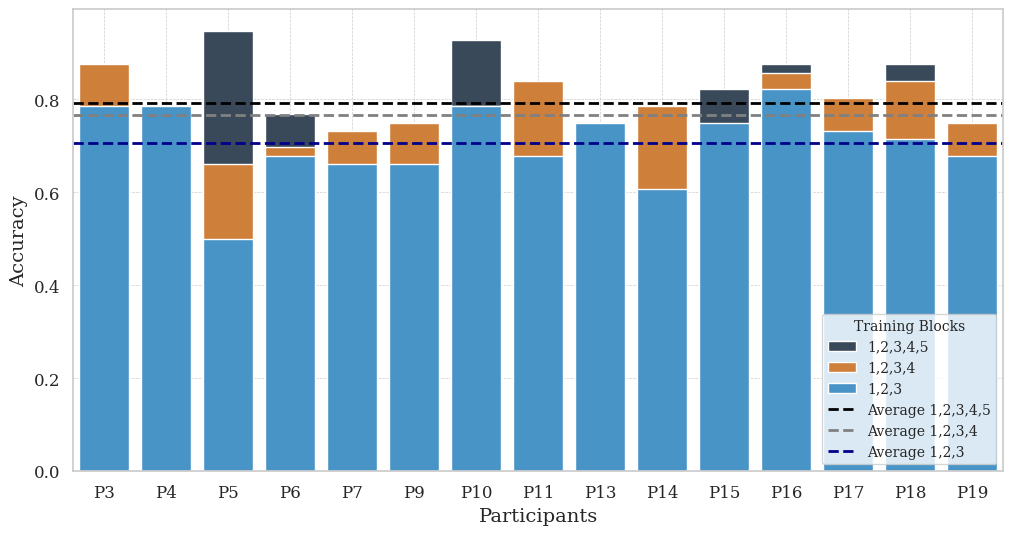

In [210]:
window_type = Window(0,"No_Params","Rec")
classifier_name = 'SVM'
train_blk_name_list  = ['12345','1234','123']
number_of_components_list = 10
number_of_selected_features_list = 10
window_time_length = 4
overlap_percent = 100
# class_1_list = ['Hand','Feet','Tongue','Mis']
class_1 = 'Mis'
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-C-Dataset-All'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [3]
data = []
p_index = 1
avg_acc_list = []
for p_num in p_num_list:
    for train_blk_name in train_blk_name_list:
        path = os.path.join(
            PATH,
            classifier_name,
            f"{number_of_components}_CSP_Components",
            f"{number_of_selected_features}-Selected_Features",
            f"{overlap_percent}%_Overlap",
            f"{window_time_length}_window_time_length",
            f"{window_type.window_name}_Window",
            f"{window_type.param_name}",
            f"{window_type.param_value}_{window_type.param_name}/"
           
        )
        path1 = path+  f"{train_blk_name}_Train/"+ f"P{p_num}.csv"

        df = pd.read_csv(path1)
        test_accuracy = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
        data.append({'Participant': f'P{p_num}', 'Train_Block': train_blk_name, 'Test_Accuracy': test_accuracy})

for train_blk_name in train_blk_name_list:
        df = pd.read_csv(path + f"{train_blk_name}_Train/" + 'AverageAcc.csv')
        avg_acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
        avg_acc_list.append(avg_acc)


df_data = pd.DataFrame(data)
custom_palette = {
    "12345": "#34495E",
    "1234": "#E67E22",
    "123": "#3498DB"
}

# Mapping for the new legend labels
legend_labels = {
    "12345": "1,2,3,4,5",
    "1234": "1,2,3,4",
    "123": "1,2,3"
}

# Update font settings
plt.rcParams.update({'font.family': 'serif'})

# Plot the bar chart using seaborn
plt.figure(figsize=(12, 6))

# Create the bar plot with the custom palette
sns.barplot(x='Participant', y='Test_Accuracy', hue='Train_Block', data=df_data, dodge=False, palette=custom_palette)

# Update title, labels, and legend with font size adjustments
# plt.title('Test Accuracy by Participant and Train Block', fontsize=16, pad=20)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Participants', fontsize=14)

# Update tick labels with font size adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
avg_colors = ['black', 'grey', 'darkblue'] # Colors for the average lines
for i, avg_acc in enumerate(avg_acc_list):
    plt.axhline(y=avg_acc, color=avg_colors[i], linestyle='--', linewidth=2)

# Modify legend
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [legend_labels[label] for label in labels]  # Replace with the new labels

# Create handles for average lines to add to the legend
avg_handles = [plt.Line2D([0], [0], color=avg_colors[i], linestyle='--', linewidth=2) for i in range(3)]
avg_labels = [f"Average {legend_labels[list(custom_palette.keys())[i]]}" for i in range(3)]

# Combine bar plot handles with average line handles
plt.legend(handles + avg_handles, new_labels + avg_labels, title='Training Blocks', fontsize=10, title_fontsize=10, loc='lower right')


plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Participants Performances/{class_1}_Participants_Performance.jpg', dpi=600, bbox_inches='tight')
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Participants Performances/{class_1}_Participants_Performance.svg', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()

## Box Charts and Error Bars

##### All Sets Code

/tmp/ipykernel_252396/542692279.py:137: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-',


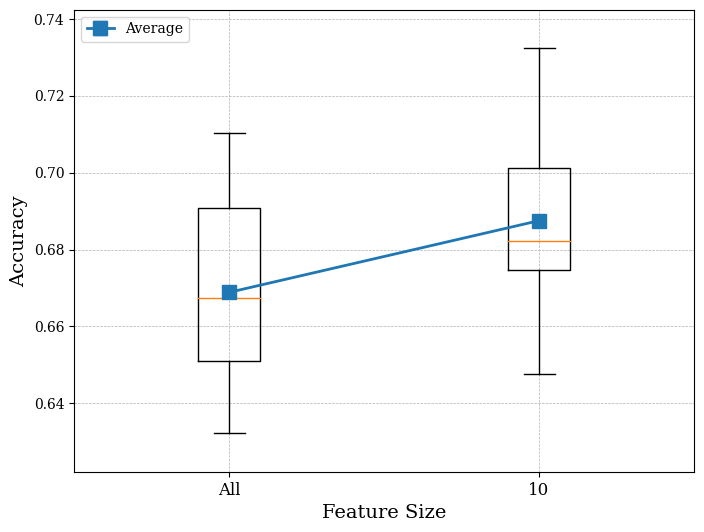

In [138]:
# 'Classifier Set'
# 'Training Blocks Set'
# 'Window Length Set'
# 'Feature Set'
target_chart = 'Features Set'
path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_chart}_stats.csv'

df = pd.read_csv(path)

columns_to_plot = df.columns[1:]

# Set x-axis labels
# xlabels = ["1", "1,2", "1,2,3", "1,2,3,4", "1,2,3,4,5"]
xlabels = ["All", 10]
x_axis_name = "Feature Size"
# xlabels = columns_to_plot

# Plot each scenario
# plot_box_chart(df, columns_to_plot, xlabels, target_chart, x_axis_name)
# plot_error_bar(df, columns_to_plot, xlabels, target_chart, x_axis_name)

# significance_matrix = [
#     [1.0, 0.22785688210925548, 0.0029177082778516494],  # XGB vs others
#     [0.22785688210925548, 1.0, 0.001],  # LDA vs others
#     [0.0029177082778516494, 0.001, 1.0]  # SVM vs others
# ]

#For those without nemenyi
plot_box_error_combined_v3(df, columns_to_plot, xlabels, target_chart, x_axis_name)

# stat_path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Nemenyi_test{target_chart}_results.csv'
# significance_matrix = pd.read_csv(stat_path).values[:, 1:] 
# print(significance_matrix)
# plot_box_error_combined_v2(df, columns_to_plot, xlabels, target_chart, x_axis_name,significance_matrix)



/tmp/ipykernel_252396/3632740620.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-',


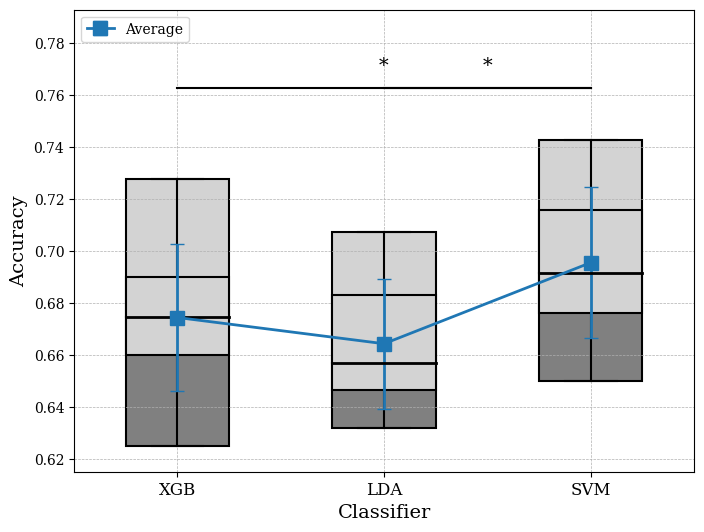

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_box_error_combined_v3(df, columns_to_plot, xlabels, target_chart, x_axis_name, significance_matrix):
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.rcParams.update({'font.family': 'serif'})

    xpos = np.arange(1, len(columns_to_plot) + 1)
    data = df[columns_to_plot].values

    # Plot the boxplots
    for i, col in enumerate(columns_to_plot):
        bp = ax.boxplot(data[:, i], positions=[xpos[i]], widths=0.5, patch_artist=True,
                        boxprops=dict(facecolor='lightgray', color='black', linewidth=1.5),
                        medianprops=dict(color='black', linewidth=2),
                        whiskerprops=dict(color='black', linewidth=1.5),
                        capprops=dict(color='black', linewidth=1.5),
                        flierprops=dict(marker='o', color='black', alpha=0.5, markersize=5))

        # Darker and lighter shading below/above the median
        box = bp['boxes'][0]
        median = bp['medians'][0].get_ydata()[0]
        lower_whisker = min(bp['whiskers'][0].get_ydata())
        upper_whisker = max(bp['whiskers'][1].get_ydata())
        x0, y0 = box.get_path().vertices[0]  # Bottom-left
        x1, y1 = box.get_path().vertices[2]  # Bottom-right
        ax.add_patch(plt.Polygon([[x0, lower_whisker], [x1, lower_whisker], [x1, median], [x0, median]],
                                  closed=True, facecolor='gray', edgecolor='black', linewidth=1.5))
        ax.add_patch(plt.Polygon([[x0, median], [x1, median], [x1, upper_whisker], [x0, upper_whisker]],
                                  closed=True, facecolor='lightgray', edgecolor='black', linewidth=1.5))

    # Error bars for the means
    means = df[columns_to_plot].mean()
    stds = df[columns_to_plot].std()
    ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', 
                marker='s', markersize=10, linewidth=2, label='Average')

    # Annotate significant differences
    for i in range(len(columns_to_plot)):
        for j in range(i+1, len(columns_to_plot)):
            if significance_matrix[i][j] < 0.05:  # Significance level (e.g., 0.05)
                y = max(data[:, i].max(), data[:, j].max()) + 0.02  # Adjust line height
                ax.plot([xpos[i], xpos[j]], [y, y], color='black', linewidth=1.5)
                ax.text((xpos[i] + xpos[j]) / 2, y + 0.005, '*', ha='center', va='bottom', color='black', fontsize=14)

    ax.set_xticks(xpos)
    ax.set_xticklabels(xlabels, fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel(x_axis_name, fontsize=14)
    ax.set_ylim([df[columns_to_plot].values.min() - 0.01, df[columns_to_plot].values.max() + 0.05])  # Adjust ylim
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend(loc='upper left')

    plt.show()

# Example Nemenyi test results as a significance matrix (p-values)
significance_matrix = [
    [1.0, 0.22785688210925548, 0.0029177082778516494],  # XGB vs others
    [0.22785688210925548, 1.0, 0.001],  # LDA vs others
    [0.0029177082778516494, 0.001, 1.0]  # SVM vs others
]

# Assuming the DataFrame and other variables are already defined
plot_box_error_combined_v3(df, columns_to_plot, xlabels, target_chart, x_axis_name, significance_matrix)


##### Feature Set

Statistics for All features:
Mean accuracy: 0.6689
Standard deviation: 0.0674
Median accuracy: 0.6791
Min accuracy: 0.4988
Max accuracy: 0.8310

Statistics for 10 features:
Mean accuracy: 0.6875
Standard deviation: 0.0665
Median accuracy: 0.6967
Min accuracy: 0.5345
Max accuracy: 0.8238



/tmp/ipykernel_15736/2695611730.py:92: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)


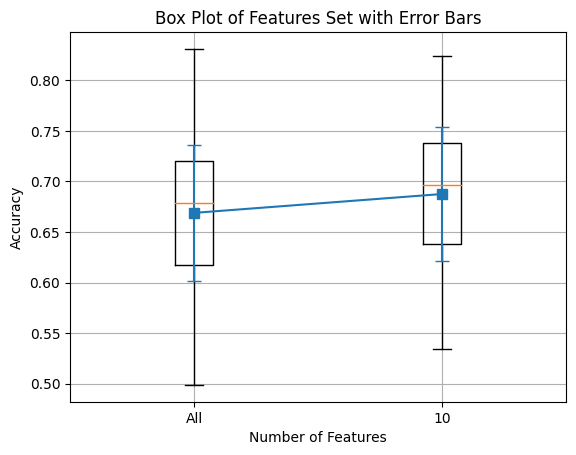

In [21]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_chart = "Features Set"

classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'

features_acc_list = []

for number_of_selected_features in number_of_selected_features_list:
    acc_list = []
    for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
        for number_of_components in number_of_components_list:
            for window_time_length in window_time_length_list:
                if window_time_length == 4:
                    overlap_percent_list = [100, 25]
                elif window_time_length == 2:
                    overlap_percent_list = [100, 50]
                elif window_time_length == 1:
                    overlap_percent_list = [100]
                for overlap_percent in overlap_percent_list:
                    for window_type in window_type_list:
                        for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                            for index, class_1 in enumerate(class_1_list):
                                path = os.path.join(
                                    Path,
                                    classifier_name,
                                    f"{number_of_components}_CSP_Components",
                                    f"{number_of_selected_features}-Selected_Features",
                                    f"{overlap_percent}%_Overlap",
                                    f"{window_time_length}_window_time_length",
                                    f"{window_type.window_name}_Window",
                                    f"{window_type.param_name}",
                                    f"{window_type.param_value}_{window_type.param_name}",
                                    f"{train_blk_name}_Train/",
                                    "AverageAcc.csv"
                                )
                                try:
                                    df = pd.read_csv(path)
                                    acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
                                    acc_list.append(acc)
                                except FileNotFoundError:
                                    print(f"File not found: {path}")
                                except IndexError:
                                    print(f"No accuracy found for class: {class_1}")

    features_acc_list.append(acc_list)

# Calculate means, standard deviations, min, and max
means = [np.mean(acc) for acc in features_acc_list]
stds = [np.std(acc) for acc in features_acc_list]
medians = [np.median(acc) for acc in features_acc_list]
mins = [np.min(acc) for acc in features_acc_list]
maxs = [np.max(acc) for acc in features_acc_list]

# Print the mean, min, and max values
for number_of_selected_features, mean, std, median, min_val, max_val in zip(number_of_selected_features_list, means, stds, medians, mins, maxs):
    print(f'Statistics for {number_of_selected_features} features:')
    print(f'Mean accuracy: {mean:.4f}')
    print(f'Standard deviation: {std:.4f}')
    print(f'Median accuracy: {median:.4f}')
    print(f'Min accuracy: {min_val:.4f}')
    print(f'Max accuracy: {max_val:.4f}')
    print()  # Empty line for separation

# Plotting
fig, ax = plt.subplots()
xpos = np.arange(len(number_of_selected_features_list))+1


# Adding grid
ax.grid(True)

# Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
# plt.title(f'Error Bars of {target_chart}')
plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Number of Features')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
ax.boxplot(features_acc_list)
ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# Setting x-axis labels
ax.set_xticks(xpos)
ax.set_xticklabels([str(i) for i in number_of_selected_features_list])







# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


##### Window Length Set

120
0
120
120
120
0
120
0
0
5 hi
Mean accuracy for 4s-0% features: 0.6955
Mean accuracy for 4s-75% features: 0.6831
Mean accuracy for 2s-0% features: 0.6830
Mean accuracy for 2s-50% features: 0.6667
Mean accuracy for 1s-0% features: 0.6626
5


/tmp/ipykernel_129374/3548953990.py:98: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)


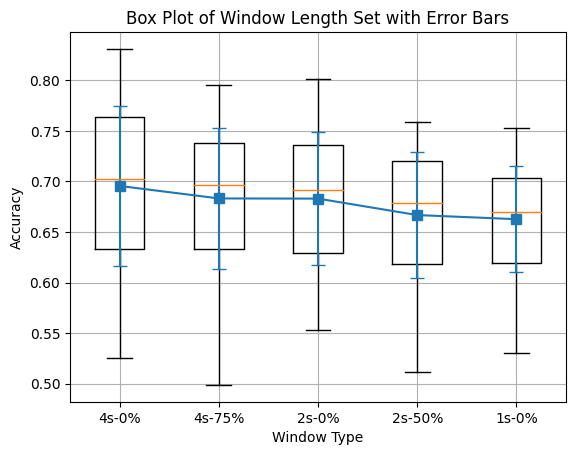

In [76]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
window_length_scenarios_list = ["4s-0%","4s-75%","2s-0%","2s-50%","1s-0%"]
target_chart = "Window Length Set"
overlap_percent_list = [100,50,25]

classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'

window_acc_list = []
for window_time_length in window_time_length_list:
    # if window_time_length == 4:
    #     overlap_percent_list = [100, 25]
    # elif window_time_length == 2:
    #     overlap_percent_list = [100, 50]
    # elif window_time_length == 1:
    #     overlap_percent_list = [100]
    for overlap_percent in overlap_percent_list:
        # print("A")
        acc_list = []
        for window_type in window_type_list:
            for number_of_selected_features in number_of_selected_features_list:
                for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
                    for number_of_components in number_of_components_list:
                        for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                            for index, class_1 in enumerate(class_1_list):
                                path = os.path.join(
                                    Path,
                                    classifier_name,
                                    f"{number_of_components}_CSP_Components",
                                    f"{number_of_selected_features}-Selected_Features",
                                    f"{overlap_percent}%_Overlap",
                                    f"{window_time_length}_window_time_length",
                                    f"{window_type.window_name}_Window",
                                    f"{window_type.param_name}",
                                    f"{window_type.param_value}_{window_type.param_name}",
                                    f"{train_blk_name}_Train/",
                                    "AverageAcc.csv"
                                )
                                try:
                                    df = pd.read_csv(path)
                                    acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
                                    acc_list.append(acc)
                                    acc_list_filling_flag = True
                                except FileNotFoundError:
                                    pass
                                    # print(f"File not found: {path}")
                                except IndexError:
                                    pass
                                    # print(f"No accuracy found for class: {class_1}")
        print(len(acc_list))   
        if(acc_list_filling_flag):
            window_acc_list.append(acc_list)
            acc_list_filling_flag = False

# Calculate means, standard deviations, min, and max
print(len(window_acc_list),"hi")
means = [np.mean(acc) for acc in window_acc_list]
stds = [np.std(acc) for acc in window_acc_list]
medians = [np.median(acc) for acc in window_acc_list]
mins = [np.min(acc) for acc in window_acc_list]
maxs = [np.max(acc) for acc in window_acc_list]

# Print the mean, min, and max values
for window_length_scenarios, mean, median, min_val, max_val in zip(window_length_scenarios_list, means, medians, mins, maxs):
    print(f'Mean accuracy for {window_length_scenarios}: {mean:.4f}')
    # print(f'Median accuracy for {window_length_scenarios}: {median:.4f}')
    # print(f'Min accuracy for {window_length_scenarios}: {min_val:.4f}')
    # print(f'Max accuracy for {window_length_scenarios}: {max_val:.4f}')

# Plotting
fig, ax = plt.subplots()
xpos = np.arange(len(window_length_scenarios_list))+1
print(len(xpos))


# Adding grid
ax.grid(True)

# Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
# plt.title(f'Error Bars of {target_chart}')
plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Window Type')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
ax.boxplot(window_acc_list)
ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)

ax.set_xticks(xpos)
ax.set_xticklabels([i for i in window_length_scenarios_list])











# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


##### Classifier Set

200
200
200
Mean accuracy for XGB: 0.6745
Mean accuracy for LDA: 0.6644
Mean accuracy for SVM: 0.6956


/tmp/ipykernel_129374/881458833.py:89: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)


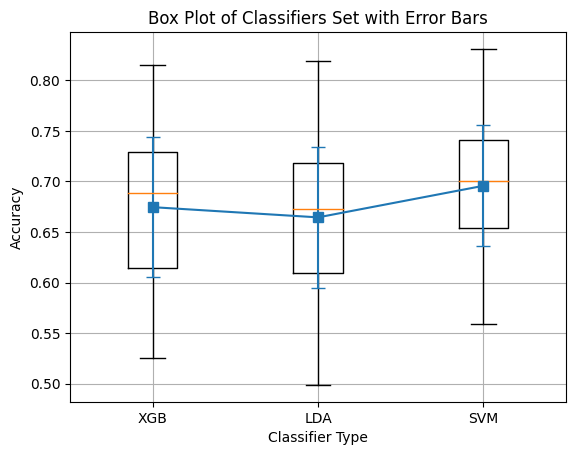

In [147]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_chart = "Classifiers Set"

classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'

classifiers_acc_list = []

for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
    acc_list = []
    for number_of_selected_features in number_of_selected_features_list:
        for number_of_components in number_of_components_list:
            for window_time_length in window_time_length_list:
                if window_time_length == 4:
                    overlap_percent_list = [100, 25]
                elif window_time_length == 2:
                    overlap_percent_list = [100, 50]
                elif window_time_length == 1:
                    overlap_percent_list = [100]
                for overlap_percent in overlap_percent_list:
                    for window_type in window_type_list:
                        for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                            for index, class_1 in enumerate(class_1_list):
                                path = os.path.join(
                                    Path,
                                    classifier_name,
                                    f"{number_of_components}_CSP_Components",
                                    f"{number_of_selected_features}-Selected_Features",
                                    f"{overlap_percent}%_Overlap",
                                    f"{window_time_length}_window_time_length",
                                    f"{window_type.window_name}_Window",
                                    f"{window_type.param_name}",
                                    f"{window_type.param_value}_{window_type.param_name}",
                                    f"{train_blk_name}_Train/",
                                    "AverageAcc.csv"
                                )
                                try:
                                    df = pd.read_csv(path)
                                    acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
                                    acc_list.append(acc)
                                except FileNotFoundError:
                                    print(f"File not found: {path}")
                                except IndexError:
                                    print(f"No accuracy found for class: {class_1}")
    print(len(acc_list))
    classifiers_acc_list.append(acc_list)

# Calculate means, standard deviations, min, and max
means = [np.mean(acc) for acc in classifiers_acc_list]
stds = [np.std(acc) for acc in classifiers_acc_list]
medians = [np.median(acc) for acc in classifiers_acc_list]
mins = [np.min(acc) for acc in classifiers_acc_list]
maxs = [np.max(acc) for acc in classifiers_acc_list]

# Print the mean, min, and max values
for classifier_name, mean, median, min_val, max_val in zip(classifier_dic.keys(), means, medians, mins, maxs):
    print(f'Mean accuracy for {classifier_name}: {mean:.4f}')
    # print(f'Median accuracy for {classifier_name}: {median:.4f}')
    # print(f'Min accuracy for {classifier_name}: {min_val:.4f}')
    # print(f'Max accuracy for {classifier_name}: {max_val:.4f}')

# Plotting
fig, ax = plt.subplots()
xpos = np.arange(len(list(classifier_dic.keys())))+1


# Adding grid
ax.grid(True)

# Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
# plt.title(f'Error Bars of {target_chart}')
plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Classifier Type')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
ax.boxplot(classifiers_acc_list)
ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# Setting x-axis labels
ax.set_xticks(xpos)
ax.set_xticklabels([item for item in classifier_dic.keys()])







# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


##### Training Blocks Set

120
120
120
120
120
Mean accuracy for 1: 0.5874
Mean accuracy for 12: 0.6433
Mean accuracy for 123: 0.6896
Mean accuracy for 1234: 0.7246
Mean accuracy for 12345: 0.7460


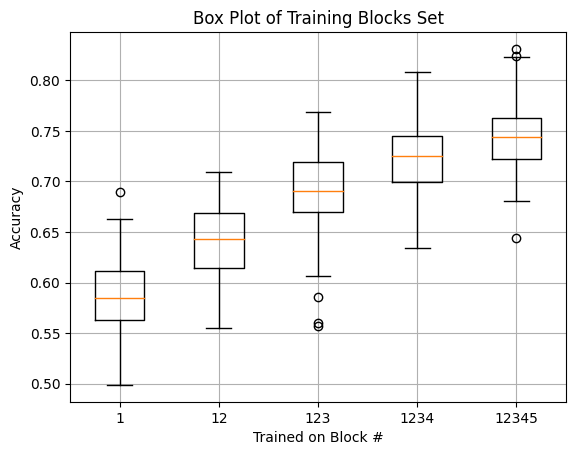

In [93]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_chart = "Training Blocks Set"

classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
train_blk_set_dic = reversed_data = {k: train_blk_set_dic[k] for k in reversed(train_blk_set_dic)}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'

tr_blks_acc_list = []
for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
    acc_list = []
    for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
        for number_of_selected_features in number_of_selected_features_list:
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                                for index, class_1 in enumerate(class_1_list):
                                    path = os.path.join(
                                        Path,
                                        classifier_name,
                                        f"{number_of_components}_CSP_Components",
                                        f"{number_of_selected_features}-Selected_Features",
                                        f"{overlap_percent}%_Overlap",
                                        f"{window_time_length}_window_time_length",
                                        f"{window_type.window_name}_Window",
                                        f"{window_type.param_name}",
                                        f"{window_type.param_value}_{window_type.param_name}",
                                        f"{train_blk_name}_Train/",
                                        "AverageAcc.csv"
                                    )
                                    try:
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
                                    except FileNotFoundError:
                                        print(f"File not found: {path}")
                                    except IndexError:
                                        print(f"No accuracy found for class: {class_1}")
    print(len(acc_list))
    tr_blks_acc_list.append(acc_list)

# Calculate means, standard deviations, min, and max
means = [np.mean(acc) for acc in tr_blks_acc_list]
stds = [np.std(acc) for acc in tr_blks_acc_list]
medians = [np.median(acc) for acc in tr_blks_acc_list]
mins = [np.min(acc) for acc in tr_blks_acc_list]
maxs = [np.max(acc) for acc in tr_blks_acc_list]

# Print the mean, min, and max values
for train_blk_set_name, mean, median, min_val, max_val in zip(train_blk_set_dic.keys(), means, medians, mins, maxs):
    print(f'Mean accuracy for {train_blk_set_name}: {mean:.4f}')
    # print(f'Median accuracy for {train_blk_set_name}: {median:.4f}')
    # print(f'Min accuracy for {train_blk_set_name}: {min_val:.4f}')
    # print(f'Max accuracy for {train_blk_set_name}: {max_val:.4f}')

# Plotting
fig, ax = plt.subplots()
xpos = np.arange(len(list(tr_blks_acc_list)))+1


# Adding grid
ax.grid(True)

# Adding titles and labels
plt.title(f'Box Plot of {target_chart}')
# plt.title(f'Error Bars of {target_chart}')
# plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Trained on Block #')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
ax.boxplot(tr_blks_acc_list)
# ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# Setting x-axis labels
ax.set_xticks(xpos)
ax.set_xticklabels([item for item in train_blk_set_dic.keys()])







# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


##### Tasks Set

150
150
150
150
Mean accuracy for Hand: 0.7055
Mean accuracy for Feet: 0.6741
Mean accuracy for Tongue: 0.6682
Mean accuracy for Mis: 0.6650


/tmp/ipykernel_129374/3208654382.py:89: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)


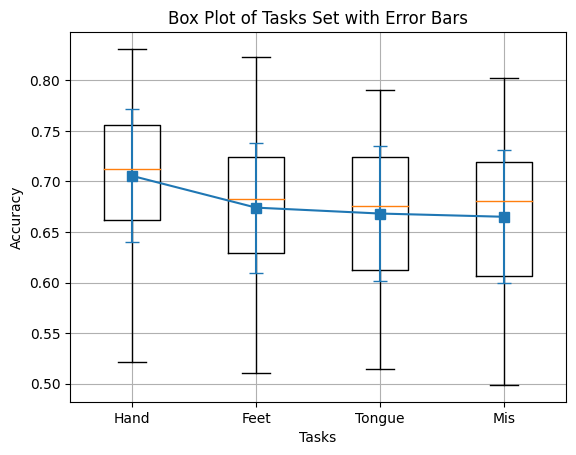

In [98]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_chart = "Tasks Set"

classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
# train_blk_set_dic = reversed_data = {k: train_blk_set_dic[k] for k in reversed(train_blk_set_dic)}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'

task_acc_list = []
for index, class_1 in enumerate(class_1_list):
    acc_list = []
    for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
        for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
            for number_of_selected_features in number_of_selected_features_list:
                for number_of_components in number_of_components_list:
                    for window_time_length in window_time_length_list:
                        if window_time_length == 4:
                            overlap_percent_list = [100, 25]
                        elif window_time_length == 2:
                            overlap_percent_list = [100, 50]
                        elif window_time_length == 1:
                            overlap_percent_list = [100]
                        for overlap_percent in overlap_percent_list:
                            for window_type in window_type_list:
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            "AverageAcc.csv"
                                        )
                                        try:
                                            df = pd.read_csv(path)
                                            acc = df.loc[df['class'] == class_1, 'test_acc'].values[0]
                                            acc_list.append(acc)
                                        except FileNotFoundError:
                                            print(f"File not found: {path}")
                                        except IndexError:
                                            print(f"No accuracy found for class: {class_1}")
    print(len(acc_list))
    task_acc_list.append(acc_list)

# Calculate means, standard deviations, min, and max
means = [np.mean(acc) for acc in task_acc_list]
stds = [np.std(acc) for acc in task_acc_list]
medians = [np.median(acc) for acc in task_acc_list]
mins = [np.min(acc) for acc in task_acc_list]
maxs = [np.max(acc) for acc in task_acc_list]

# Print the mean, min, and max values
for class_name, mean, median, min_val, max_val in zip(class_1_list, means, medians, mins, maxs):
    print(f'Mean accuracy for {class_name}: {mean:.4f}')
    # print(f'Median accuracy for {class_name}: {median:.4f}')
    # print(f'Min accuracy for {class_name}: {min_val:.4f}')
    # print(f'Max accuracy for {class_name}: {max_val:.4f}')

# Plotting
fig, ax = plt.subplots()
xpos = np.arange(len(class_1_list))+1


# Adding grid
ax.grid(True)

# Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
# plt.title(f'Error Bars of {target_chart}')
plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Tasks')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
ax.boxplot(task_acc_list)
ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# Setting x-axis labels
ax.set_xticks(xpos)
ax.set_xticklabels([item for item in class_1_list])







# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


### Participants Set

600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
Mean accuracy for P3: 0.6672
Mean accuracy for P4: 0.7213
Mean accuracy for P5: 0.6419
Mean accuracy for P6: 0.6445
Mean accuracy for P7: 0.6628
Mean accuracy for P9: 0.7153
Mean accuracy for P10: 0.6425
Mean accuracy for P11: 0.7142
Mean accuracy for P13: 0.6759
Mean accuracy for P14: 0.6679
Mean accuracy for P15: 0.6792
Mean accuracy for P16: 0.6699
Mean accuracy for P17: 0.7050
Mean accuracy for P18: 0.6770
Mean accuracy for P19: 0.6881


/tmp/ipykernel_129374/2164332463.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)


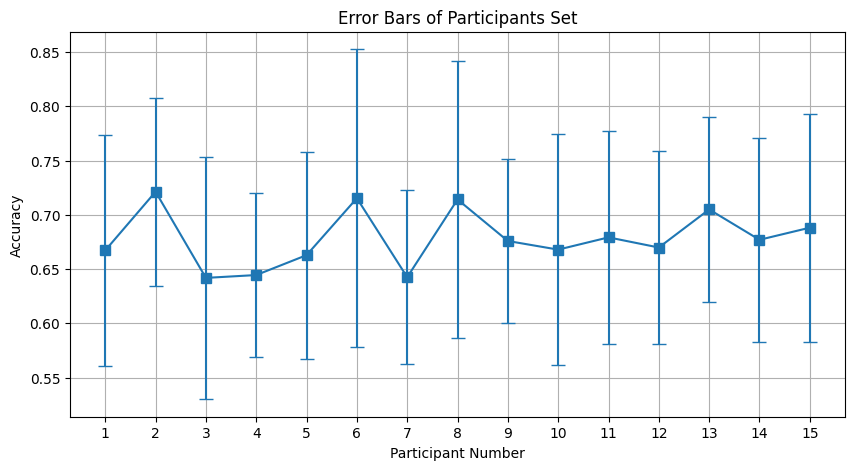

In [110]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_chart = "Participants Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4, 2, 1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
participant_acc_list = []
for p_num in p_num_list:
    acc_list = []
    for number_of_selected_features in number_of_selected_features_list:
        for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)

    print(len(acc_list))
    participant_acc_list.append(acc_list)

# Calculate means, standard deviations, min, and max
means = [np.mean(acc) for acc in participant_acc_list]
stds = [np.std(acc) for acc in participant_acc_list]
medians = [np.median(acc) for acc in participant_acc_list]
mins = [np.min(acc) for acc in participant_acc_list]
maxs = [np.max(acc) for acc in participant_acc_list]

# Print the mean, min, and max values
for p_num, mean, median, min_val, max_val in zip(p_num_list, means, medians, mins, maxs):
    print(f'Mean accuracy for P{p_num}: {mean:.4f}')
    # print(f'Median accuracy for P{p_num}: {median:.4f}')
    # print(f'Min accuracy for P{p_num}: {min_val:.4f}')
    # print(f'Max accuracy for P{p_num}: {max_val:.4f}')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
xpos = np.arange(len(p_num_list))+1


# Adding grid
ax.grid(True)

# Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
plt.title(f'Error Bars of {target_chart}')
# plt.title(f'Box Plot of {target_chart} with Error Bars')


plt.xlabel('Participant Number')
plt.ylabel('Accuracy')


# Plot the boxplot and error charts
# ax.boxplot(participant_acc_list, widths=0.3)
ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# Setting x-axis labels
ax.set_xticks(xpos)
# ax.set_xticklabels(['P'.join(str(i)) for i in participant_acc_list])







# Save the plot
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# Display the plot
plt.show()


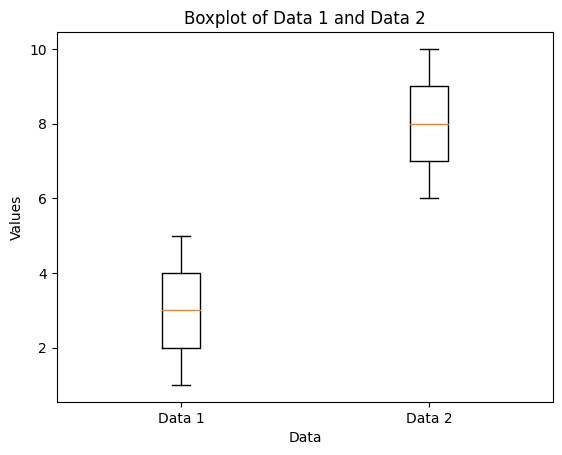

In [75]:
import matplotlib.pyplot as plt

# Data
data1 = [1, 2, 3, 4, 5]
data2 = [6, 7, 8, 9, 10]

# Combine the data into a list
data = [data1, data2]

# Creating the boxplot
plt.boxplot(data)

# Adding labels to x-axis
plt.xticks([1, 2], ['Data 1', 'Data 2'])

# Adding title and labels
plt.title('Boxplot of Data 1 and Data 2')
plt.xlabel('Data')
plt.ylabel('Values')

# Display the plot
plt.show()


## Bar Charts

In [ ]:
#For Plotting 1 scenario 4 tasks and 5 train sets

# Define a more visually appealing and colorblind-friendly color palette
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628']
train_blk_set_dic = {"1": colors[0], "12": colors[1], "123": colors[2], "1234": colors[3], "12345": colors[4]}

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis']
labels_to_x = {'Hand': 1, 'Feet': 2, 'Tongue': 3, 'Mis': 4}

x = [labels_to_x[label] * 4 for label in labels]
x = np.array(x)

PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
classifier_name = "XGB"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Window(0,"No_Params","Rec")
train_blk_list = [1, 12, 123, 1234, 12345]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(14, 8))  # Adjust figure size as needed

# Generate legend patches with the new color palette
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

for index, (train_blk, color) in enumerate(train_blk_set_dic.items()):
    acc_list_1 = return_acc(PATH, classifier_name, number_of_components, number_of_selected_features, overlap_percent, window_time_length, window_type, train_blk)
    blk_values = acc_list_1
    ax.bar(x + index * bar_width * 1.5, blk_values, width=bar_width, color=color)

# Enhance font readability
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'  # Consider using 'Times New Roman' or 'Arial' for academic papers

# Refine axis for readability
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Enhance ticks for clarity
ax.tick_params(axis='x', colors='black', direction='out', length=5, width=1)
ax.tick_params(axis='y', colors='black', direction='out', length=5, width=1)

# Set x ticks and labels with refined font settings
ax.set_xticks(x+1)
ax.set_xticklabels(labels, fontsize=16, fontweight='bold')

# Set y ticks and labels with refined font settings and add accuracy label to y-axis
y_ticks = np.linspace(0, 1, 11)  # Adjust range and number of ticks as needed
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{int(val * 100)}%' for val in y_ticks], fontsize=14)
ax.set_ylabel('Accuracy', fontsize=16)  # Adding accuracy label to the y-axis

# Refine grid lines for better visibility
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.7, linewidth=1)
ax.grid(axis='x', linestyle='--', color='gray', alpha=0.7, linewidth=1)

# Add legend and title with enhanced appearance
ax.legend(legend_patches, train_blk_set_dic.keys(), fontsize=12, title='Training Blocks', title_fontsize='14', frameon=False)
ax.set_title('Classification of Continuous Motor Imagery Tasks With XGB and Rectangular Window', fontsize=18, fontweight='bold', family='serif')  # Adjust title

plt.tight_layout()  # Adjust layout for better fit
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/EEG-Ground/{classifier_name}_{number_of_selected_features}SF_{window_type.window_name}_{window_type.param_name}_{window_type.param_value}_{overlap_percent}%.jpg', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
#For Plotting 4 scenario 4 tasks and 5 train sets

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}




x = [labels_to_x[label]*4 for label in labels]
x = np.array(x)



PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
classifier_name = "XGB"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 25
window_time_length = 4
window_type = "Rec"

train_blk_set_dic = {"1":"red","12":"blue","123":"green","1234":"orange","12345":"grey"}
n = len(train_blk_list)
m = list(range(-(n-1)//2, (n-1)//2 + 1))
# train_blk_list = ["12345","1234","123","12","1"]
number_of_selected_features_list = [10,2]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(50, 20))

legend_labels = ['b1', 'b12', 'b123', 'b1234', 'b12345']
colors = train_blk_set_dic.values()
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
for number_of_selected_features in number_of_selected_features_list:
    for index, (train_blk, color) in enumerate(zip(train_blk_set_dic.keys(), train_blk_set_dic.values())):
        classifier_name = "XGB"
        acc_list_1 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        classifier_name = "LDA"
        acc_list_2 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        blk_values = acc_list_1 + acc_list_2
        print(blk_values)
        if number_of_selected_features == 2:
            blk_values = [-j for j in blk_values]
            
        ax.bar(x + m[index]*bar_width*1.5, blk_values, width=bar_width, color=color)



ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=40)
ax.set_yticklabels(ax.get_yticks(), fontsize=40)  # Adjust the fontsize as needed

y_max = max(ax.get_yticks())
y_ticks = [i*10/100  for i in range(-10,11)]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{float(val)}%' for val in y_ticks], fontsize=20)
ax.grid(True, linestyle='--')

# y_ticks = ax.get_yticks()
# y_max = max(y_ticks)
# for i in range(1, 10):
#     y_value = i / 10 * y_max
#     ax.axhline(y=y_value, color='gray', linestyle='--')
ax.legend(legend_patches, legend_labels, fontsize=20, title='Legend')
ax.set_title(f'{window_type}_{overlap_percent}%', fontsize=40, weight='bold')






xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
ax.text(xlims[0], ylims[1], 'LDA/10F', horizontalalignment='left', verticalalignment='top', fontsize=40, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], 'XGB/10F', horizontalalignment='right', verticalalignment='top', fontsize=40, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], 'LDA/2F', horizontalalignment='left', verticalalignment='bottom', fontsize=40, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], 'XGB/2F', horizontalalignment='right', verticalalignment='bottom', fontsize=40, weight='bold')

# Show the plot
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/{window_type}_{overlap_percent}%.svg', dpi=300, bbox_inches='tight')
plt.show()



30
[0.5714285714285714, 0.5833333333333333, 0.5392857142857143, 0.5351190476190476, 0.6053571428571428, 0.5678571428571428, 0.5958333333333333, 0.5773809523809523]
[0.5714285714285714, 0.5833333333333333, 0.5392857142857143, 0.5351190476190476]
(8,)
0
[0.7057142857142857, 0.6700000000000002, 0.5964285714285714, 0.5721428571428572, 0.6678571428571429, 0.6707142857142856, 0.6299999999999999, 0.6407142857142858]
[0.7057142857142857, 0.6700000000000002, 0.5964285714285714, 0.5721428571428572]
(8,)
1
[0.7696428571428572, 0.749107142857143, 0.7294642857142858, 0.6821428571428572, 0.7446428571428572, 0.7526785714285714, 0.7142857142857144, 0.6946428571428572]
[0.7696428571428572, 0.749107142857143, 0.7294642857142858, 0.6821428571428572]
(8,)
2
[0.8011904761904761, 0.8011904761904761, 0.7571428571428572, 0.7488095238095237, 0.8035714285714285, 0.8023809523809524, 0.7238095238095238, 0.7202380952380952]
[0.8011904761904761, 0.8011904761904761, 0.7571428571428572, 0.7488095238095237]
(8,)
3
[0.

/tmp/ipykernel_55196/1152420815.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontsize=40)


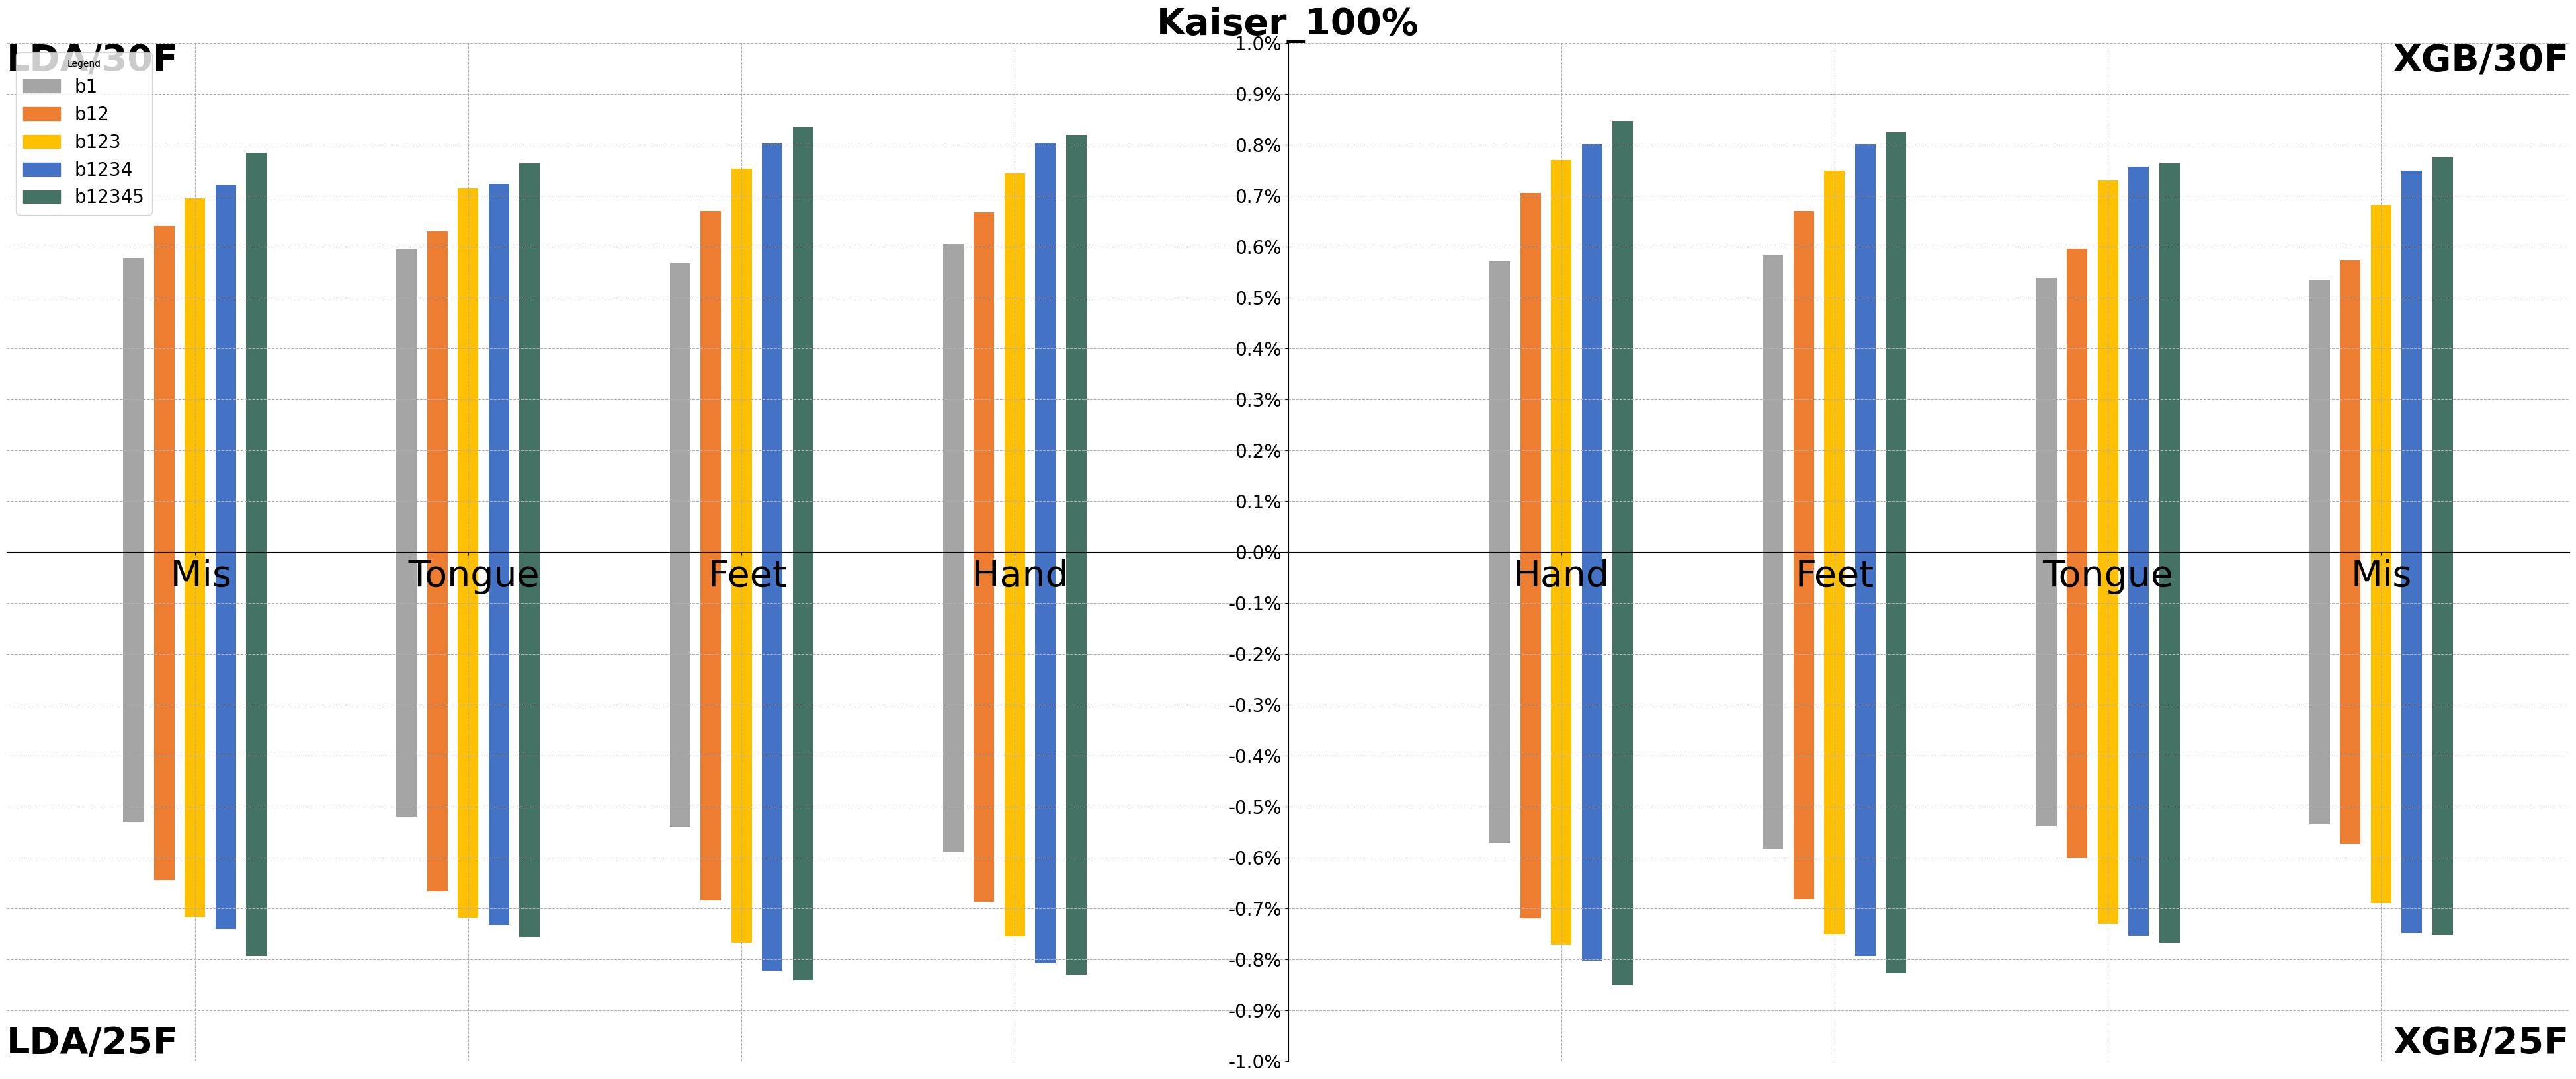

In [56]:
#For Plotting 4 scenario 4 tasks and 5 train sets(Previous version in case of corruption)

# Labels for the bars
labels = ['Hand', 'Feet', 'Tongue', 'Mis', ' Hand', ' Feet', ' Tongue', ' Mis']
labels_to_x = {'Hand':1, 'Feet':2, 'Tongue':3, 'Mis':4, ' Hand':-1, ' Feet':-2, ' Tongue':-3, ' Mis':-4}


x = [labels_to_x[label]*4 for label in labels]
x = np.array(x)




train_blk_set_dic = {
    "1": (165/255, 165/255, 165/255),   # Gray RGB tuple
    "12": (237/255, 125/255, 49/255),   # Orange RGB tuple 
    "123": (255/255, 192/255, 0/255),   # Yellow RGB tuple
    "1234": (68/255, 114/255, 196/255), # Blue RGB tuple
    "12345": (68/255, 114/255, 100/255) # Green RGB tuple
}




train_blk_list = ["12345","1234","123","12","1"]
n = len(train_blk_list)
m = list(range(-(n-1)//2, (n-1)//2 + 1))
PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = "Kaiser"
number_of_selected_features_list = [30,25]
bar_width = 0.3
fig, ax = plt.subplots(figsize=(50, 20))
classifier_list = ["XGB","LDA"]
legend_labels = ['b1', 'b12', 'b123', 'b1234', 'b12345']
colors = train_blk_set_dic.values()
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]

for number_of_selected_features in number_of_selected_features_list:
    print(number_of_selected_features) 
    for index, (train_blk, color) in enumerate(zip(train_blk_set_dic.keys(), train_blk_set_dic.values())):
        classifier_name = "XGB"
        acc_list_1 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        classifier_name = "LDA"
        acc_list_2 = return_acc(PATH,classifier_name,number_of_components,number_of_selected_features,overlap_percent,window_time_length,window_type,train_blk)
        blk_values = acc_list_1 + acc_list_2
        print(blk_values)
        print(acc_list_1)
        if number_of_selected_features == number_of_selected_features_list[1]:
            blk_values = [-j for j in blk_values]
        print(x.shape)  
        
        
        ax.bar(x + m[index]*bar_width*1.5, blk_values, width=bar_width, color=color)
        print(index)



ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.tick_left()
ax.xaxis.tick_bottom()
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=40)
ax.set_yticklabels(ax.get_yticks(), fontsize=40)

y_max = max(ax.get_yticks())
y_ticks = [i*10/100  for i in range(-10,11)]
ax.set_yticks(y_ticks)
ax.set_yticklabels([f'{float(val)}%' for val in y_ticks], fontsize=20)
ax.grid(True, linestyle='--')

ax.legend(legend_patches, legend_labels, fontsize=20, title='Legend')
ax.set_title(f'{window_type}_{overlap_percent}%', fontsize=40, weight='bold')






xlims = ax.get_xlim()
ylims = ax.get_ylim()

# Top left (B)
s_f = number_of_selected_features_list
clf = classifier_list
ax.text(xlims[0], ylims[1], f'{clf[1]}/{s_f[0]}F', horizontalalignment='left', verticalalignment='top', fontsize=40, weight='bold')

# Top right (A)
ax.text(xlims[1], ylims[1], f'{clf[0]}/{s_f[0]}F', horizontalalignment='right', verticalalignment='top', fontsize=40, weight='bold')

# Bottom left (C)
ax.text(xlims[0], ylims[0], f'{clf[1]}/{s_f[1]}F', horizontalalignment='left', verticalalignment='bottom', fontsize=40, weight='bold')

# Bottom right (D)
ax.text(xlims[1], ylims[0], f'{clf[0]}/{s_f[1]}F', horizontalalignment='right', verticalalignment='bottom', fontsize=40, weight='bold')

# Show the plot
plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Bar-Charts/{clf[0]}_{clf[1]}_{s_f[0]}F_{s_f[1]}F_{window_type}_{overlap_percent}%.svg', dpi=300, bbox_inches='tight')
plt.show()



## Activity Timeline plot

In [60]:
print(vote_acc)
print(accuracy_te)
print(len(y_pr_te))

0.7981651376146789
0.7798165137614679
218


[12, 20, 28, 44, 60, 72, 92, 112, 120, 140, 156, 172, 184, 196, 216, 224]
[12.0, 8.0, 8.0, 16.0, 16.0, 12.0, 20.0, 20.0, 8.0, 20.0, 16.0, 16.0, 12.0, 12.0, 20.0, 8.0]


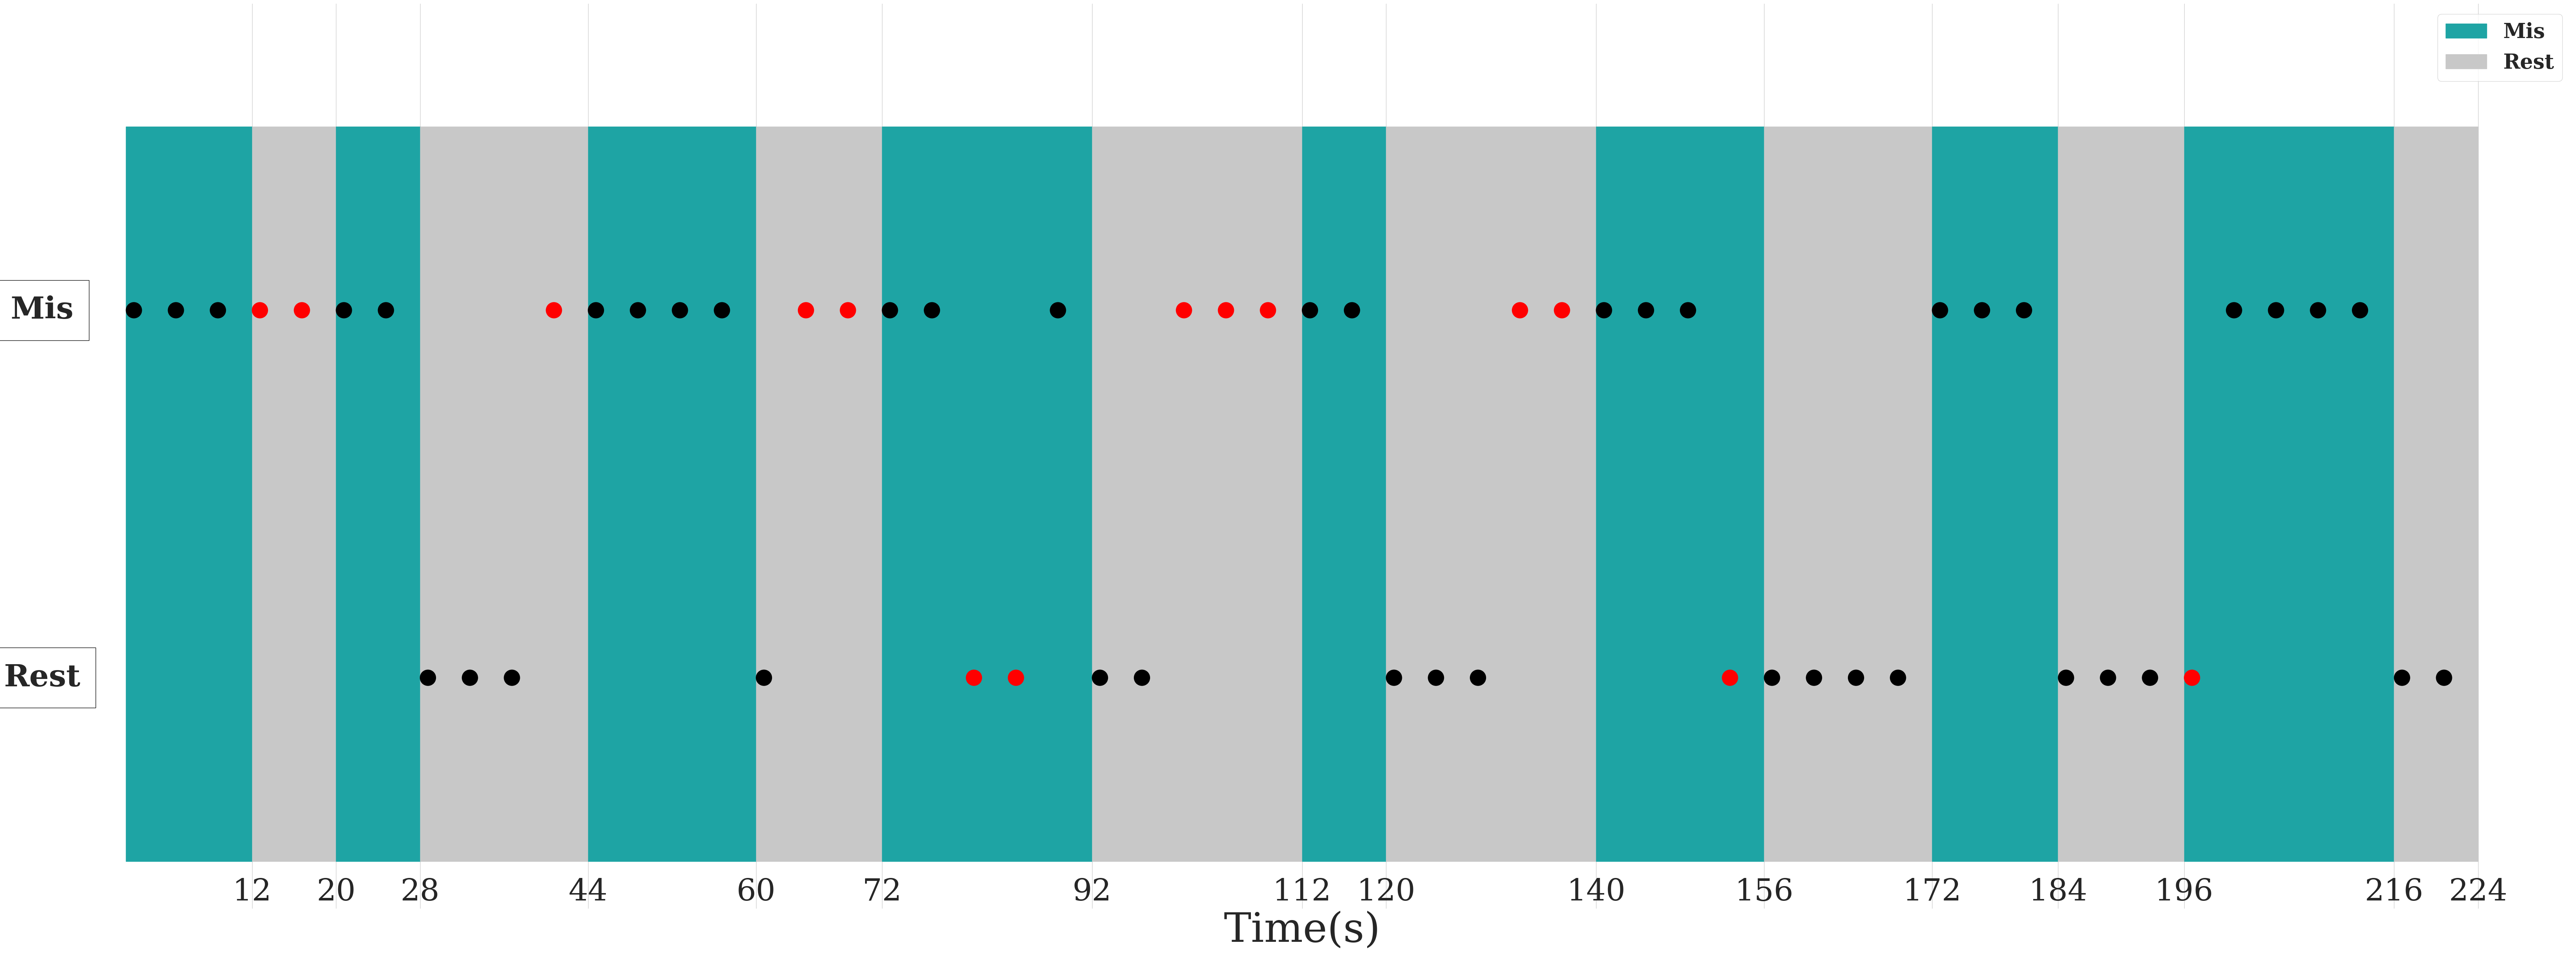

In [231]:
#without ovrlap scenario (Set the following params before running aslo must have the classifer accuracy before running)
extra_space = 9
b_num_list = [5,6]
class_1 = "Mis"
classifier = "SVM"

overlap_percent = 100
window_time = 4
cte = 4
accumulated_times = []
previous_time = 0
times = []
for b_num in b_num_list:
    trial_num = trial_order[b_num].index(class_1)
    task_times,rest_times = get_task_rest_times(b_num)
    trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
    times+=trial_times
res = [cte*x/window_time for x in times]

for i in times:
    current_time = previous_time + i
    accumulated_times.append(current_time)
    previous_time = current_time

print(accumulated_times)
print(res)

# Create a figure

plt.rcParams.update({'font.family': 'serif'})

# Define the size of the figure
fig_width = 70  # Example width
fig_height = 70  # Example height
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Define the extra space color if needed (optional)
# extra_space_color = 'white'

# Initialize variables
x = 0
for i, width in enumerate(res):
    color = (30/255, 164/255, 164/255) if i % 2 == 0 else (200/255, 200/255, 200/255)
    rect = Rectangle((x, 0), width, fig_height, color=color)
    ax.add_patch(rect)
    x += width

# Accumulatively add circles
circle_size = 0.75
for (index, i), (index_, j) in zip(enumerate(y_pr_te), enumerate(Y_te)):
    if i == j:
        if i == 1:
            circle = Circle((4*index + circle_size, 3*fig_height/4), circle_size, color='black')
        else:
            circle = Circle((4*index + circle_size, 1*fig_height/4), circle_size, color='black')
    else:
        if i == 1:
            circle = Circle((4*index + circle_size, 3*fig_height/4), circle_size, color='red')
        else:
            circle = Circle((4*index + circle_size, 1*fig_height/4), circle_size, color='red')
    ax.add_patch(circle)

# Font properties for bold text
font_prop_bold = FontProperties(weight='bold')

# Add labels for class and rest
offset = 1
ax.text(-extra_space + offset, 3*fig_height/4, class_1, ha='center', va='center', fontsize=60, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)
ax.text(-extra_space + offset, 1*fig_height/4, 'Rest', ha='center', va='center', fontsize=60, 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)

# Set aspect ratio and axis limits
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-extra_space, x + extra_space)
ax.set_ylim(-0.5*extra_space, fig_height + 1.3*extra_space)

# Remove unnecessary spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set x-axis tick labels with the desired font size
ax.set_xticks(accumulated_times)
ax.set_xticklabels([f"{int(t)}" for t in accumulated_times], fontsize=60, y=0.04)

# Add legend
legend_labels = [class_1, 'Rest']
legend_handles = [Rectangle((0, 0), 1, 1, color=(30/255, 164/255, 164/255)),
                  Rectangle((0, 0), 1, 1, color=(200/255, 200/255, 200/255))]
font_prop = FontProperties(weight='bold', size=40)

ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right', prop=font_prop, bbox_to_anchor=(1, 1),fontsize=80)

# Set axis labels and title with font sizes
ax.set_xlabel('Time(s)', fontsize=80)
# ax.set_title(f'Activity Timeline For {window_type.window_name} Window,{overlap_percent}% Shifting and {Classifier} Classifier', fontsize=80, weight='bold')

# Hide the y-axis
ax.yaxis.set_visible(False)

# Adjust layout to fit the elements
plt.tight_layout()

# Save the plot
fig.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Activity Timeline/{class_1}_P{p_num}_{classifier}_Activity_Timeline.jpg', format='jpg', dpi=600)
fig.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Activity Timeline/{class_1}_P{p_num}_{classifier}_Activity_Timeline.svg', format='svg', dpi=600)

# Show the plot
plt.show()
#done



[12, 20, 28, 44, 60, 72, 92, 112, 120, 140, 156, 172, 184, 196, 216, 224]
[12.0, 8.0, 8.0, 16.0, 16.0, 12.0, 20.0, 20.0, 8.0, 20.0, 16.0, 16.0, 12.0, 12.0, 20.0, 8.0]
174 true
44 false


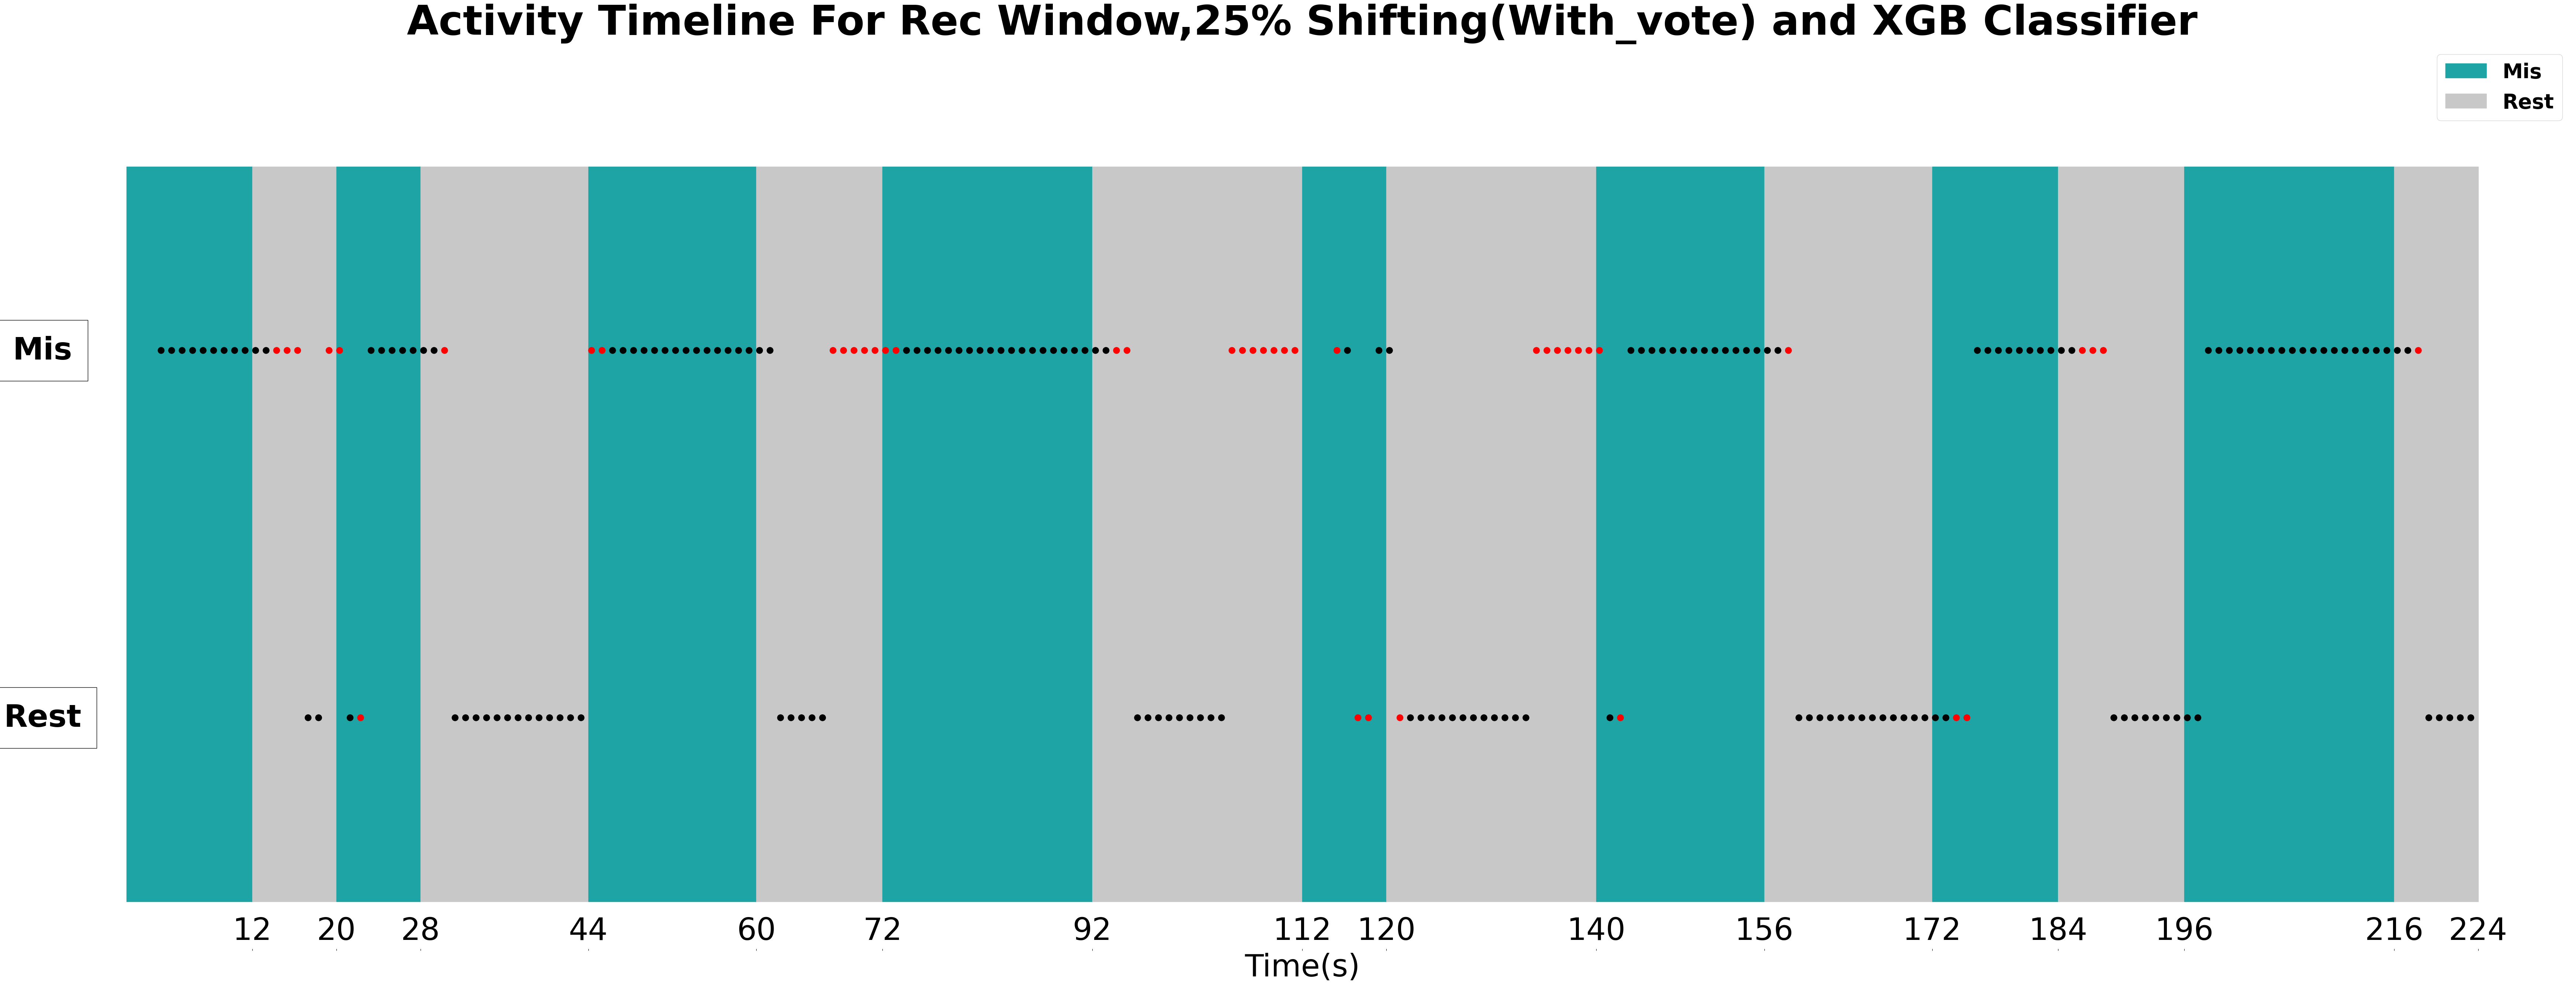

In [62]:
#with ovrlap scenario (Set the following params before running aslo must have the classifer accuracy before running)

extra_space = 9
b_num_list = [5,6]
class_1 = "Mis"
Classifier = "XGB"
vote_flag = "With_vote"
window_type = Window(0,"No_Params","Rec")
overlap_percent = 25
window_time = 4
cte = 4
accumulated_times = []
previous_time = 0
times = []
for b_num in b_num_list:
    trial_num = trial_order[b_num].index(class_1)
    task_times,rest_times = get_task_rest_times(b_num)
    trial_times = trial_times_genertor(task_times[trial_num],rest_times[trial_num])
    times+=trial_times
res = [cte*x/window_time for x in times]

for i in times:
    current_time = previous_time + i
    accumulated_times.append(current_time)
    previous_time = current_time

print(accumulated_times)
print(res)


fig_width = 70 
fig_height = 70 
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


x = 0
for i, width in enumerate(res):
    color = (30/255, 164/255, 164/255) if i % 2 == 0 else (200/255, 200/255, 200/255)
    rect = Rectangle((x, 0), width, fig_height, color=color)
    ax.add_patch(rect)
    x += width


# Accumulatively add circles

total_width = sum(res)  # Total width of all rectangles
circle_size = 0.3
t = 0
f = 0
for (index, i), (index_, j) in zip(enumerate(y_pr_te_Vote), enumerate(Y_te_Vote)):
    if index >=109:

        if (i == j):
            t+=1
            if i == 1:
                circle = Circle((6+index + circle_size , 3*fig_height/4), circle_size, color='black')
            else:
                circle = Circle((6+index + circle_size , 1*fig_height/4), circle_size, color='black')
        else:
            f+=1
            if i == 1:
                circle = Circle((6+index + circle_size , 3*fig_height/4), circle_size, color='red')
            else:
                circle = Circle((6+index + circle_size , 1*fig_height/4), circle_size, color='red')

    else:
        if (i == j):
            t+=1
            if i == 1:
                circle = Circle((3+index + circle_size , 3*fig_height/4), circle_size, color='black')
            else:
                circle = Circle((3+index + circle_size , 1*fig_height/4), circle_size, color='black')
        else:
            f+=1
            if i == 1:
                circle = Circle((3+index + circle_size , 3*fig_height/4), circle_size, color='red')
            else:
                circle = Circle((3+index + circle_size , 1*fig_height/4), circle_size, color='red')

    ax.add_patch(circle)

print(t,"true")
print(f,"false")

font_prop_bold = FontProperties(weight='bold')
offset = 1
ax.text(-extra_space + offset, 3*fig_height/4, class_1, ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)
ax.text(-extra_space + offset, 1*fig_height/4, 'Rest', ha='center', va='center', fontsize=60, bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.5'), fontproperties=font_prop_bold)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-extra_space, x + extra_space)
ax.set_ylim(-0.5*extra_space, fig_height + 1.3*extra_space)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

#set times
ax.set_xticks(accumulated_times)
ax.set_xticklabels([f"{int(t)}" for t in accumulated_times], fontsize=60,y=0.04)


# Add legend
legend_labels = [class_1, 'Rest']
legend_handles = [Rectangle((0, 0), 1, 1, color=(30/255, 164/255, 164/255)),
                  Rectangle((0, 0), 1, 1, color=(200/255, 200/255, 200/255))]
font_prop = FontProperties(weight='bold', size=40)
ax.legend(handles=legend_handles, labels=legend_labels, loc='upper right', prop=font_prop, bbox_to_anchor=(1, 1))

# Set axis labels and title
ax.set_xlabel('Time(s)', fontsize=60)
ax.set_title(f'Activity Timeline For {window_type.window_name} Window,{overlap_percent}% Shifting({vote_flag}) and {Classifier} Classifier', fontsize=80, weight='bold')

# Hide the y-axis
ax.yaxis.set_visible(False)

# Show plot
plt.tight_layout()
fig.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Task-classification-chart/Corrected-pics/P09_{class_1}_2blk_Test_{window_type.window_name}_{overlap_percent}%_{Classifier}_{vote_flag}.svg', format='svg', dpi=600)
plt.show()


## CSP Component Trend

[0.8553571428571427, 0.8553571428571429, 0.8607142857142858, 0.8446428571428571, 0.8517857142857143, 0.8464285714285713, 0.8464285714285713, 0.8553571428571429, 0.8517857142857143]


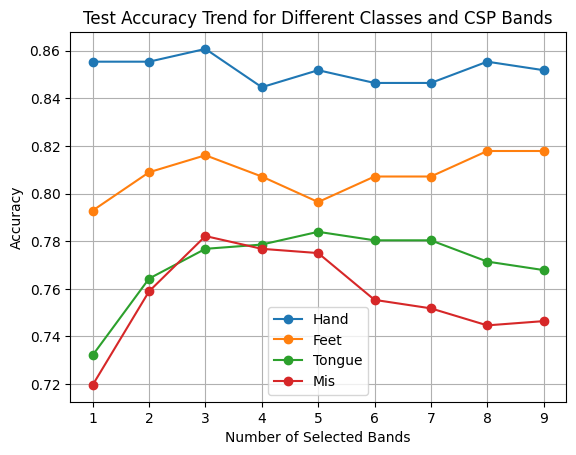

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

hand_acc = []
feet_acc = []
tongue_acc = []
mis_acc = []
number_of_bands = 10
num_of_compnent = 10
bands_list = np.arange(1,number_of_bands)
for num_of_bands in bands_list:
    # /home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/XGB/10_CSP_Components_5OptimalF/10-Selected_Features/100%_Overlap/4_window_time_length/Kaiser_Window/Beta/1.5_Beta/12345_Train/AverageAcc.csv
    # path = f"/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/XGB/{num_of_compnent}_CSP_Components/No Selected Features-Selected_Features/100%_Overlap/4_window_time_length/Kaiser_Window/Beta/1.5_Beta/1234_Train/AverageAcc.csv"
    path = f"/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/XGB/{num_of_compnent}_CSP_Components_{num_of_bands}OptimalF/10-Selected_Features/100%_Overlap/4_window_time_length/Kaiser_Window/Beta/1.5_Beta/12345_Train/AverageAcc.csv"
    df = pd.read_csv(path)
    hand_acc.append(df[df['class'] == 'Hand']['test_acc'].values[0])
    feet_acc.append(df[df['class'] == 'Feet']['test_acc'].values[0])
    tongue_acc.append(df[df['class'] == 'Tongue']['test_acc'].values[0])
    mis_acc.append(df[df['class'] == 'Mis']['test_acc'].values[0])

print(hand_acc)


# Plotting trend lines
plt.plot(bands_list, hand_acc, marker='o', label='Hand')
plt.plot(bands_list, feet_acc, marker='o', label='Feet')
plt.plot(bands_list, tongue_acc, marker='o', label='Tongue')
plt.plot(bands_list, mis_acc, marker='o', label='Mis')

plt.grid(True)

# Add labels and legend
plt.xlabel('Number of Selected Bands')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Trend for Different Classes and CSP Bands')
plt.legend()
# plt.savefig("/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/CSP-component-trend/csp_trend_XGB_4Kaiser1.5B_100%_No_SF_1234Train.svg", format='svg')
plt.show()


# Stats

## Data Preparation For Statistical Analysis

### Data Table for Mann-withny Test

In [39]:
path_c = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-C-Dataset-TestOnRest/XGB/10_CSP_Components/10-Selected_Features/100%_Overlap/4_window_time_length/Rec_Window/No_Params/0_No_Params/'
path_s = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-S-Dataset-TestOnRest/XGB/10_CSP_Components/10-Selected_Features/Rec_Window/No_Params/0_No_Params/'
p_num_list_c = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
p_num_list_s = [2,3,4,5,6,7,8,10,11,12,13,14,15]
Training_blk_list = [1,12,123,1234]
class_list = ['Hand','Feet','Tongue','Mis']
paradigm_list = ['Continuous', 'Switch']
acc_list = []
Mann_W_data = {
    "Participant": ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "P11", "P12", "P13", "P14", "P15",
                    "_P1", "_P2", "_P3", "_P4", "_P5", "_P6", "_P7", "_P8", "_P9", "_P10", "_P11", "_P12", "_P13"],
    "Hand": [""] * 28,
    "Feet": [""] * 28,
    "Tongue": [""] * 28,
    "Mis": [""] * 28,
    "Paradigm": ["Continuous"] * 15 + ["Switch"] * 13
}

Mann_W_df = pd.DataFrame(Mann_W_data)
for paradigm in paradigm_list:
    if paradigm == "Continuous":
        path = path_c
        p_num_list = p_num_list_c
        p_prefix = 'P'
    elif paradigm == "Switch":
        path = path_s
        p_num_list = p_num_list_s
        p_prefix = '_P'

    for index,p_num in enumerate(p_num_list):
        for class_1 in class_list:
            acc_list = []
            for tr_blk in Training_blk_list:
                df = pd.read_csv(path+f'{tr_blk}_Train/P{p_num}.csv')
                class_acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                acc_list.append(class_acc)
            avg_acc = np.average(acc_list)
            print(avg_acc)

            participant_str = f'{p_prefix}{index+1}'
            print(participant_str)
            participant_index = Mann_W_df[Mann_W_df['Participant'] == participant_str].index[0]
            Mann_W_df.at[participant_index, class_1] = avg_acc

Mann_W_df.to_csv('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/Mann_Whitney_XGB_DF(Average Over Blks).csv')

0.7044642857142858
P1
0.6125
P1
0.6705357142857142
P1
0.7208333333333333
P1
0.8736607142857143
P2
0.7648809523809524
P2
0.7328869047619048
P2
0.6590773809523809
P2
0.5566964285714285
P3
0.6724702380952381
P3
0.6550595238095238
P3
0.5805059523809524
P3
0.6541666666666667
P4
0.6495535714285714
P4
0.634672619047619
P4
0.6336309523809524
P4
0.687797619047619
P5
0.7050595238095237
P5
0.6434523809523809
P5
0.5776785714285714
P5
0.7876488095238096
P6
0.740625
P6
0.6254464285714285
P6
0.6505952380952381
P6
0.6513392857142857
P7
0.625
P7
0.5574404761904762
P7
0.6830357142857142
P7
0.700595238095238
P8
0.8672619047619048
P8
0.6025297619047619
P8
0.6708333333333334
P8
0.635267857142857
P9
0.6778273809523809
P9
0.6897321428571429
P9
0.7223214285714286
P9
0.8733630952380952
P10
0.6623511904761905
P10
0.5550595238095238
P10
0.6041666666666666
P10
0.8269531407886517
P11
0.6555059523809524
P11
0.6150297619047618
P11
0.658779761904762
P11
0.5866071428571429
P12
0.6007440476190475
P12
0.6869047619047619

In [62]:
x = 0.5892857142857143 + 0.7380952380952381 + 0.9107142857142857 + 0.8928571428571429
x/4

0.7827380952380952

### Feature Set

In [139]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_stat = "Features Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
features_acc_list = []

for number_of_selected_features in number_of_selected_features_list:
    p_acc_list = []
    for p_num in p_num_list:
        acc_list = []
        for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
        print(len(acc_list))
        p_acc_list.append(acc_list)
    features_acc_list.append(p_acc_list)



print(len(features_acc_list[0][0]))
print(np.mean(features_acc_list[0]))


mean_acc_list = []
for p_index, p_num in enumerate(p_num_list):
    all_features_mean = np.mean(features_acc_list[0][p_index])
    ten_features_mean = np.mean(features_acc_list[1][p_index])
    mean_acc_list.append([p_num, all_features_mean, ten_features_mean])

# Create a DataFrame and save it as CSV
df = pd.DataFrame(mean_acc_list, columns=["Participant Number", "All Features", "10 Features"])
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)

# # Calculate means, standard deviations, min, and max
# means = [np.mean(acc) for acc in features_acc_list]
# stds = [np.std(acc) for acc in features_acc_list]
# medians = [np.median(acc) for acc in features_acc_list]
# mins = [np.min(acc) for acc in features_acc_list]
# maxs = [np.max(acc) for acc in features_acc_list]

# # Print the mean, min, and max values
# for number_of_selected_features, mean, median, min_val, max_val in zip(number_of_selected_features_list, means, medians, mins, maxs):
#     print(f'Mean accuracy for {number_of_selected_features} features: {mean:.4f}')
#     # print(f'Median accuracy for {number_of_selected_features} features: {median:.4f}')
#     # print(f'Min accuracy for {number_of_selected_features} features: {min_val:.4f}')
#     # print(f'Max accuracy for {number_of_selected_features} features: {max_val:.4f}')

# # Plotting
# fig, ax = plt.subplots()
# xpos = np.arange(len(number_of_selected_features_list))+1


# # Adding grid
# ax.grid(True)

# # Adding titles and labels
# plt.title(f'Box Plot of {target_chart}')
# # plt.title(f'Error Bars of {target_chart}')
# # plt.title(f'Box Plot of {target_chart} with Error Bars')


# plt.xlabel('Number of Features')
# plt.ylabel('Accuracy')


# # Plot the boxplot and error charts
# ax.boxplot(features_acc_list)
# # ax.errorbar(xpos, means, yerr=stds, fmt='o', capsize=5, linestyle='-', marker='s', markersize=7)





# # Setting x-axis labels
# ax.set_xticks(xpos)
# ax.set_xticklabels([str(i) for i in number_of_selected_features_list])







# # Save the plot
# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.svg', dpi=300)
# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxChart.jpg', dpi=300)

# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.svg', dpi=300)
# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_ErrorChart.jpg', dpi=300)

# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.svg', dpi=300)
# # plt.savefig(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/SVGs/Box-Error-Charts/{target_chart}_BoxErrorChart.jpg', dpi=300)

# # Display the plot
# plt.show()


300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
0.6688604599848866


In [138]:
(7589285714285714 + 6294642857142857)/2

6941964285714286.0

### Window Length Set

In [145]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
window_length_scenarios_list = ["4s-0%","4s-75%","2s-0%","2s-50%","1s-0%"]
target_stat = "Window Length Set"
overlap_percent_list = [100,50,25]
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
window_acc_list = []

for window_time_length in window_time_length_list:
    for overlap_percent in overlap_percent_list:
        p_acc_list = []
        for p_num in p_num_list:
            acc_list = []
            for window_type in window_type_list:
                for number_of_selected_features in number_of_selected_features_list:
                    for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
                        for number_of_components in number_of_components_list:
                            for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        try:
                                            df = pd.read_csv(path)
                                            acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                            acc_list.append(acc)
                                            acc_list_filling_flag = True

                                        except FileNotFoundError:
                                            pass
                                            # print(f"File not found: {path}")
                                        except IndexError:
                                            pass
                                            # print(f"No accuracy found for class: {class_1}")
            
            if(acc_list_filling_flag):                              
                print(len(acc_list))
                p_acc_list.append(acc_list)
                acc_list_filling_flag = False
                window_acc_list_flag = True
        if(window_acc_list_flag):        
            window_acc_list.append(p_acc_list)
            window_acc_list_flag = False



print(len(window_acc_list[1]))
print(np.mean(window_acc_list[0]))


mean_acc_list = []
for p_index, p_num in enumerate(p_num_list):
    four_s_100 = np.mean(window_acc_list[0][p_index])
    four_s_25 = np.mean(window_acc_list[1][p_index])
    two_s_100 = np.mean(window_acc_list[2][p_index])
    two_s_50 = np.mean(window_acc_list[3][p_index])
    one_s_100 = np.mean(window_acc_list[4][p_index])
    mean_acc_list.append([p_num, four_s_100, four_s_25,two_s_100,two_s_50,one_s_100])

# Create a DataFrame and save it as CSV
df = pd.DataFrame(mean_acc_list, columns=["Participant Number"]+window_length_scenarios_list)
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)



120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
15
0.6954960317460317


### Classifier Set

In [148]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_stat = "Classifier Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
classifier_acc_list = []

for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
    p_acc_list = []
    for p_num in p_num_list:
        acc_list = []
        for number_of_selected_features in number_of_selected_features_list:
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
        print(len(acc_list))
        p_acc_list.append(acc_list)
    classifier_acc_list.append(p_acc_list)



print(len(classifier_acc_list[0][0]))
print(np.mean(classifier_acc_list[0]))


mean_acc_list = []
for p_index, p_num in enumerate(p_num_list):
    XGB_ = np.mean(classifier_acc_list[0][p_index])
    LDA_ = np.mean(classifier_acc_list[1][p_index])
    SVM_ = np.mean(classifier_acc_list[2][p_index])
    mean_acc_list.append([p_num, XGB_, LDA_, SVM_])

# Create a DataFrame and save it as CSV
df = pd.DataFrame(mean_acc_list, columns=["Participant Number"] + list(classifier_dic.keys()))
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)


200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
0.6745124899637513


### Training Blocks Set

In [ ]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_stat = "Training Blocks Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
train_blk_set_dic = reversed_data = {k: train_blk_set_dic[k] for k in reversed(train_blk_set_dic)}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
tr_blks_acc_list = []


for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
    p_acc_list = []
    for p_num in p_num_list:
        acc_list = []
        for number_of_selected_features in number_of_selected_features_list:
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
                                for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
        print(len(acc_list))
        p_acc_list.append(acc_list)
    tr_blks_acc_list.append(p_acc_list)




mean_acc_list = []
for p_index, p_num in enumerate(p_num_list):
    first = np.mean(tr_blks_acc_list[0][p_index])
    first_two = np.mean(tr_blks_acc_list[1][p_index])
    first_three = np.mean(tr_blks_acc_list[2][p_index])
    first_four = np.mean(tr_blks_acc_list[3][p_index])
    first_five = np.mean(tr_blks_acc_list[4][p_index])
    mean_acc_list.append([p_num, first, first_two, first_three, first_four, first_five])

# Create a DataFrame and save it as CSV
df = pd.DataFrame(mean_acc_list, columns=["Participant Number"] + ['Blk' + item for item in train_blk_set_dic.keys()])
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)


120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120
120


### Tasks Set

In [ ]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_stat = "Tasks Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
train_blk_set_dic = reversed_data = {k: train_blk_set_dic[k] for k in reversed(train_blk_set_dic)}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]
tasks_acc_list = []

for index, class_1 in enumerate(class_1_list):
    p_acc_list = []
    for p_num in p_num_list:
        acc_list = []
        for number_of_selected_features in number_of_selected_features_list:
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
                                for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
        print(len(acc_list))
        p_acc_list.append(acc_list)
    tasks_acc_list.append(p_acc_list)




mean_acc_list = []
for p_index, p_num in enumerate(p_num_list):
    Hand = np.mean(tasks_acc_list[0][p_index])
    Feet = np.mean(tasks_acc_list[1][p_index])
    Tongue = np.mean(tasks_acc_list[2][p_index])
    Mis = np.mean(tasks_acc_list[3][p_index])

    mean_acc_list.append([p_num, Hand, Feet, Tongue, Mis ])

# Create a DataFrame and save it as CSV
df = pd.DataFrame(mean_acc_list, columns=["Participant Number"] + class_1_list)
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)


150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150


### Participants Set

In [170]:
Path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Results-v6'
number_of_selected_features_list = ["All",10]
target_stat = "Participants Set"
classifier_dic = {"XGB": XGBClassifier(), "LDA": LDA(), "SVM": SVM()}
number_of_components_list = [10]
window_time_length_list = [4,2,1]
window_type_list = [Window(0, "No_Params", "Rec")]
train_blk_set_dic = {"12345": [0, 1, 2, 3, 4], "1234": [0, 1, 2, 3], "123": [0, 1, 2], "12": [0, 1], "1": [0]}
test_blk_set_dic = {"67_1": [5, 6], "67_2": [5, 6], "67_3": [5, 6], "67_4": [5, 6], "67_5": [5, 6]}
# train_blk_set_dic = {"12345": [0, 1, 2, 3, 4]}
# test_blk_set_dic = {"67_1": [5, 6]}
class_1_list = ['Hand', 'Feet', 'Tongue', 'Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14,15,16,17,18,19]
# p_num_list = [9]


p_acc_list = []
for p_num in p_num_list:
    acc_list = []
    for index, class_1 in enumerate(class_1_list):
        for number_of_selected_features in number_of_selected_features_list:
            for number_of_components in number_of_components_list:
                for window_time_length in window_time_length_list:
                    if window_time_length == 4:
                        overlap_percent_list = [100, 25]
                    elif window_time_length == 2:
                        overlap_percent_list = [100, 50]
                    elif window_time_length == 1:
                        overlap_percent_list = [100]
                    for overlap_percent in overlap_percent_list:
                        for window_type in window_type_list:
                            for classifier, classifier_name in zip(classifier_dic.values(), classifier_dic.keys()):
                                for train_blk_set, train_blk_name, test_blk_set, test_blk_name in zip(train_blk_set_dic.values(), train_blk_set_dic.keys(), test_blk_set_dic.values(), test_blk_set_dic.keys()):
                                        path = os.path.join(
                                            Path,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/",
                                            f"P{p_num}.csv"
                                        )
                                        df = pd.read_csv(path)
                                        acc = df.loc[df['class1'] == class_1, 'test_acc'].values[0]
                                        acc_list.append(acc)
    print(len(acc_list))
    p_acc_list.append(acc_list)




mean_acc_list = np.array(p_acc_list).T.tolist()

df = pd.DataFrame(mean_acc_list, columns= ['P'+ str(item) for item in p_num_list])
csv_path = os.path.join(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv')
df.to_csv(csv_path, index=False)


600
600
600
600
600
600
600
600
600
600
600
600
600
600
600


## Friedmen Test for Classification


In [192]:
target_stat = 'Window Length Set'
path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv'
df = pd.read_csv(path)

# Select all columns except the first one (Participant Number)
columns_to_test = df.columns[1:]  # Excludes the first column

# Run the Friedman test
stat, p_value = friedmanchisquare(*[df[col] for col in columns_to_test])
# stat, p_value = friedmanchisquare(df['XGB'], df['LDA'], df['SVM'])

# Interpret the p-value
alpha = 0.05
significance = f"There are significant differences between the {target_stat} (reject the null hypothesis)." if p_value < alpha else f"There are no significant differences between the {target_stat} (fail to reject the null hypothesis)."

# Save the results in a DataFrame
results_df = pd.DataFrame({
    "Friedman Test Statistic": [stat],
    "P-value": [p_value],
    "alpha": [alpha],
    "Significance": [significance]

})

# Save the DataFrame to a CSV file
results_df.to_csv(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Friedman_test{target_stat}_results.csv', index=False)


## Friedmen Test for TDRQ


In [10]:
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/TDR_STAT_C.xlsx'
df = pd.read_excel(path)
# df.to_csv('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/TDR_STAT_C.csv')
# Select all columns except the first one (Participant Number)
columns_to_test = df.columns[1:]  # Excludes the first column

# Run the Friedman test
stat, p_value = friedmanchisquare(*[df[col] for col in columns_to_test])
target_stat = 'MI Tasks'
# Interpret the p-value
alpha = 0.05
significance = f"There are significant differences between the {target_stat} (reject the null hypothesis)." if p_value < alpha else f"There are no significant differences between the {target_stat} (fail to reject the null hypothesis)."

# Save the results in a DataFrame
results_df = pd.DataFrame({
    "Friedman Test Statistic": [stat],
    "P-value": [p_value],
    "alpha": [alpha],
    "Significance": [significance]

})

# Save the DataFrame to a CSV file
results_df.to_csv(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Friedman_test_TDRQ_results.csv', index=False)


## Wilcoxon Test

In [10]:
target_stat = 'Features Set'
path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv'
df = pd.read_csv(path)

# Select the columns to test (excluding the first column which is Participant Number)
columns_to_test = df.columns[1:]  # Excludes the first column

alpha = 0.05
stat, p_value = wilcoxon(*[df[col] for col in columns_to_test])
significance = f"There are significant differences between the {target_stat} (reject the null hypothesis)." if p_value < alpha else f"There are no significant differences between the {target_stat} (fail to reject the null hypothesis)."


results_df = pd.DataFrame({
    "Friedman Test Statistic": [stat],
    "P-value": [p_value],
    "alpha": [alpha],
    "Significance": [significance]

})
print(results_df)
results_df.to_csv(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Wilcoxon_test{target_stat}_results.csv', index=False)



   Friedman Test Statistic   P-value  alpha  \
0                      0.0  0.000061   0.05   

                                        Significance  
0  There are significant differences between the ...  


## Dunn-Bonferroni Test

In [229]:
target_stat = 'Classifier Set'
path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv'
df = pd.read_csv(path)


data = df.iloc[:, 1:].T
dunn_results = sp.posthoc_dunn(data.values, p_adjust='holm')
print(dunn_results)
dunn_df = pd.DataFrame(dunn_results, index=data.columns, columns=data.columns)

dunn_df.to_csv(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Dunn_Bonferroni_test_{target_stat}_results.csv')



          1         2         3
1  1.000000  0.260175  0.174599
2  0.260175  1.000000  0.013713
3  0.174599  0.013713  1.000000


## Nemenyi Test

In [11]:
target_stat = 'Features Set'
path = f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/{target_stat}_stats.csv'
df = pd.read_csv(path)

data = df.iloc[:, 1:]

# Perform the Nemenyi post hoc test
nemenyi_results = pd.DataFrame(sp.posthoc_nemenyi_friedman(data.values))
nemenyi_results.columns = data.columns
nemenyi_results.index = data.columns
nemenyi_df = nemenyi_results
print(nemenyi_df)
nemenyi_df.to_csv(f'/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Nemenyi_test{target_stat}_results.csv')

              All Features  10 Features
All Features         1.000        0.001
10 Features          0.001        1.000


## Mann-Whitney Test for Classification

In [43]:
file_path = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/Mann_Whitney_XGB_DF(Average Over Blks).csv"
df = pd.read_csv(file_path)

continuous_df = df[df['Paradigm'] == 'Continuous']
switch_df = df[df['Paradigm'] == 'Switch']

tasks = ['Hand', 'Feet', 'Tongue', 'Mis']
u_statistic = []
p_value = []
alpha = [0.05] * len(tasks)

for task in tasks:
    stat, p = mannwhitneyu(continuous_df[task], switch_df[task], alternative='two-sided')
    u_statistic.append(stat)
    p_value.append(p)

# Creating the result dataframe
result_df = pd.DataFrame({
    '': ['U-statistic', 'p-value', 'alpha'],
    'Hand': [u_statistic[0], p_value[0], alpha[0]],
    'Feet': [u_statistic[1], p_value[1], alpha[1]],
    'Tongue': [u_statistic[2], p_value[2], alpha[2]],
    'Mis': [u_statistic[3], p_value[3], alpha[3]]
})
result_df.to_csv('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Mann_Whitney_XGB_Results(Average Over Blks).csv')
print(result_df)


                     Hand      Feet    Tongue        Mis
0  U-statistic  85.000000  77.00000  42.00000  46.000000
1      p-value   0.580411   0.35689   0.01129   0.018807
2        alpha   0.050000   0.05000   0.05000   0.050000


## Mann-Whitney Test for TDRQ

In [3]:
file_path = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Tables/Mann_Whitney_TDRQ.csv"
df = pd.read_csv(file_path)

continuous_df = df[df['Paradigm'] == 'Continuous']
switch_df = df[df['Paradigm'] == 'Switch']

tasks = ['Hand', 'Feet', 'Tongue', 'Mis']
u_statistic = []
p_value = []
alpha = [0.05] * len(tasks)

for task in tasks:
    stat, p = mannwhitneyu(continuous_df[task], switch_df[task], alternative='two-sided')
    u_statistic.append(stat)
    p_value.append(p)

# Creating the result dataframe
result_df = pd.DataFrame({
    '': ['U-statistic', 'p-value', 'alpha'],
    'Hand': [u_statistic[0], p_value[0], alpha[0]],
    'Feet': [u_statistic[1], p_value[1], alpha[1]],
    'Tongue': [u_statistic[2], p_value[2], alpha[2]],
    'Mis': [u_statistic[3], p_value[3], alpha[3]]
})
result_df.to_csv('/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG-v2/EEG/Stats/Results/Mann_Whitney_TDRQ_Results.csv')
print(result_df)


                      Hand        Feet     Tongue        Mis
0  U-statistic  100.500000  119.000000  71.000000  94.000000
1      p-value    0.907748    0.328276   0.229819   0.889891
2        alpha    0.050000    0.050000   0.050000   0.050000


# Side Analysis

In [38]:
# #Frame Maker
PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v4/XGB/"
df = pd.read_csv(PATH+'frame.csv')
p_num_list = [3,4,5,6,7,9,10,11,13,14,15]
for p_num in p_num_list:
    df.to_csv(PATH+'P'+str(p_num)+'.csv',index=False)



In [ ]:
path = os.path.join(
    PATH,
    classifier_name,
    f"{number_of_components}_CSP_Components",
    f"{number_of_selected_features}-Selected_Features",
    overlapflag,
    f"{window_time_length}_window_time_length",
    f"{window_type}_Window",
    f"{train_blk_name}_Train/",
)
print(path + f"P{p_num}.csv")

## Path Cleaner

In [87]:
#Path Cleaner
class Window:
    def __init__(self,param_value,param_name,window_name):
        self.param_value = param_value
        self.param_name = param_name
        self.window_name = window_name


classifier_dic = {"XGB":XGBClassifier()}
number_of_components_list = [10]
number_of_selected_features_list = [10]
overlap_percent_list = [100]
channels_to_remove = []
number_of_channels = NUMBER_OF_CHANNELS
window_time_length_list = [4]
vote_window = 3
# window_type_list_ = [Window(None,"Rec"),Window(1.5,"Kaiser"),Window(2,"Kaiser"),Window(2.5,"Kaiser"),Window(3,"Kaiser"),Window(3.5,"Kaiser")]
window_type_list_ = [Window(1.55,"Beta","Kaiser")]
# window_type_list_ = [Window(0,"No_Params","Rec")]
train_blk_set_dic = {"12345":[0,1,2,3,4],"1234":[0,1,2,3],"123":[0,1,2],"12":[0,1],"1":[0]}
test_blk_set_dic = {"67":[5,6],"567":[4,5,6],"4567":[3,4,5,6],"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
# train_blk_set_dic = {"12":[0,1],"1":[0]}
# test_blk_set_dic = {"34567":[2,3,4,5,6],"234567":[1,2,3,4,5,6]}
# train_blk_set_dic = {"12345":[0,1,2,3,4]}
# test_blk_set_dic = {"67":[5,6]}
# class_1_list = ['Hand','Feet','Tongue','Mis']
class_1_list = ['Hand','Feet','Tongue','Mis']
class_2 = 'Rest'
p_num_list = [3,4,5,6,7,9,10,11,13,14]
# p_num_list = [3]
PATH = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3/"


for classifier, classifier_name in zip(classifier_dic.values(),classifier_dic.keys()):
    for number_of_components in number_of_components_list:
        for number_of_selected_features in number_of_selected_features_list:
                for overlap_percent in overlap_percent_list:                  
                    for window_time_length in window_time_length_list:
                        sliding_time_tr = sliding_time_te = window_time_length*overlap_percent/100
                        if overlap_percent != 100:
                            window_type_list = [Window(0,"No_Params","Rec")]  
                        else:
                            window_type_list = window_type_list_

                        for window_type in window_type_list:
                            for train_blk_set,train_blk_name,test_blk_set,test_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys(),test_blk_set_dic.values(),test_blk_set_dic.keys()):
                                p = 0
                                for p_num in p_num_list:
                                    for index, class_1 in enumerate(class_1_list):
                                        path = os.path.join(
                                            PATH,
                                            classifier_name,
                                            f"{number_of_components}_CSP_Components",
                                            f"{number_of_selected_features}-Selected_Features",
                                            f"{overlap_percent}%_Overlap",
                                            f"{window_time_length}_window_time_length",
                                            f"{window_type.window_name}_Window",
                                            f"{window_type.param_name}",
                                            f"{window_type.param_value}_{window_type.param_name}",
                                            f"{train_blk_name}_Train/"
                                        )
                                        if index == 0:
                                            clean_csv(path + f"P{p_num}.csv")
                                            # save_csv(new_row, path + f"P{p_num}.csv")
                                        else:
                                            pass
                                            # save_csv(new_row, path + f"P{p_num}.csv")

                                        print(
                                        f"classifier_name = {classifier_name}\n"
                                        f"number_of_components = {number_of_components}\n"
                                        f"number_of_selected_features = {number_of_selected_features}\n"
                                        f"overlap_percent = {overlap_percent}\n"
                                        f"window_time_length = {window_time_length}\n"
                                        f"window_type = {window_type.window_name}\n"
                                        f"window_param_name = {window_type.param_name},window_param_value = {window_type.param_value} \n"
                                        f"train_blk_name = {train_blk_name}\n"
                                        f"Participant = {p_num}"
                                        )

                                        # print(train_acc_list,"train",class_1)
                                        # print(test_acc_list,"test",class_1)

                                        
                                    p+=1
                                # get_results_average(path,p_num_list,class_1_list)
                                if os.path.exists(path+"AverageAcc.csv"):
                                    remove_csv(path+"AverageAcc.csv")
                                    remove_csv(path+"ResultsOfAll.csv")
                                else:
                                    pass
                                    # get_results_average(path,p_num_list,class_1_list)
                                


classifier_name = XGB
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Kaiser
window_param_name = Beta,window_param_value = 1.55 
train_blk_name = 12345
Participant = 3
classifier_name = XGB
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Kaiser
window_param_name = Beta,window_param_value = 1.55 
train_blk_name = 12345
Participant = 3
classifier_name = XGB
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Kaiser
window_param_name = Beta,window_param_value = 1.55 
train_blk_name = 12345
Participant = 3
classifier_name = XGB
number_of_components = 10
number_of_selected_features = 10
overlap_percent = 100
window_time_length = 4
window_type = Kaiser
window_param_name = Beta,window_param_value = 1.55 
train_blk_name = 12345
Participant = 3
classifier_name = XGB
number_of_components = 10


In [ ]:
import pandas as pd

def save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
             window_time_length, window_type, train_blk_name, p_num):
    # Convert to relative path
    relative_path = os.path.join(
        classifier,
        f"{number_of_components}_CSP_Components",
        f"{number_of_selected_features}-Selected_Features",
        overlapflag,
        f"{window_time_length}_window_time_length",
        window_type,
        f"{train_blk_name}_Train",
        f"P{p_num}.csv"
    )

    # Convert relative path to absolute path
    absolute_path = os.path.abspath(relative_path)

    # Read existing CSV or create an empty DataFrame
    try:
        rf = pd.read_csv(absolute_path)
    except FileNotFoundError:
        rf = pd.DataFrame(columns=column_names_v2)

    # Create a new row DataFrame
    new_row_df = pd.DataFrame([new_row], columns=column_names_v2)

    # Concatenate existing DataFrame and new row DataFrame
    cf = pd.concat([rf, new_row_df], ignore_index=True)

    # Write the concatenated DataFrame to CSV
    cf.to_csv(absolute_path, index=False)

# Example usage
classifier = "XGBClassifier"
number_of_components = 10
number_of_selected_features = 10
overlapflag = "With_Overlap"
window_time_length = "4_window_time_length"
window_type = "50% Overlap"
train_blk_name = "12345"
p_num = 9

new_row = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10]
save_csv(new_row, classifier, number_of_components, number_of_selected_features, overlapflag,
         window_time_length, window_type, train_blk_name, p_num)


In [ ]:

# # Specific path and file name
# file_path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/frame.csv'  # Replace with your specific path
# df = pd.DataFrame(columns=column_names)
# # Write the DataFrame to a CSV file at the specified path
# df.to_csv(file_path, index=False)

In [ ]:
first_list = ["12345", "1234", "123", "12", "1"]

second_list = []

for item in first_list:
    result = ""
    for i in range(len(item) - 1):
        result += str(int(item[i]) + int(item[i + 1]))
    second_list.append(result)

print(second_list)


In [ ]:
train_blk_set_dic = {"01234":[0,1,2,3,4],"0123":[0,1,2,3],"012":[0,1,2],"01":[0,1],"0":[0]}
for train_blk_set,train_blk_name in zip(train_blk_set_dic.values(),train_blk_set_dic.keys()):
    print(len(train_blk_set))
    print(train_blk_name)

In [ ]:
def remove_outliers(df):
    # Specify the threshold for outliers (you can adjust this based on your data)
    threshold = 10 ** 5

    # Calculate median and MAD for each row
    median = df.iloc[:, :-1].median(axis=1)
    mad = np.median(np.abs(df.iloc[:, :-1].sub(median, axis=0)), axis=1)
    threshold_array = median + threshold * mad

    # Identify rows with values exceeding the threshold
    outliers = df.iloc[:, :-1].gt(threshold_array[:, None], axis=0).any(axis=1)

    # Remove rows identified as outliers
    clean_df = df[~outliers]

    return clean_df


In [44]:

#Pickle_converter
def data_reader(path,p_num,block_list):
    data_dict = {}
    for b_num in block_list:
        print(b_num)
        mat = loadmat(path+'P'+ str(p_num) + '/'+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
        df = pd.DataFrame(mat['Data'])
        df.to_pickle(f"{path}Pickels_Participants/P{p_num}/P{p_num}B{b_num}.pkl")
    #     data_dict[b_num] = df
    # return data_dict

In [45]:
block_list = [0,1,2,3,4,5,6]
p_num_list = [17]
path = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/Participants/'
for p_num in p_num_list:
    print("reading",p_num)
    data_reader(path,p_num,block_list)



reading 17
0
1
2
3
4
5
6


In [ ]:
print(len()data_dict_list)

In [ ]:
from scipy import stats

def remove_outliers_across_channels(df, threshold):
    # print(df.shape,"shape0")

    data_columns = df.columns[:-1]  # Excluding the label column by default

    # Separate the label column
    labels = df.iloc[:, -1]  # Assuming the label is in the last column
    data_without_label = df.iloc[:, :-1]  # DataFrame without the label column

    # Calculate Z-scores for each row
    # print(data_without_label.shape,"shape1")
    # print(data_without_label[data_columns].shape,"shape2")
    # print(data_without_label.head(10))
    data_without_label[data_columns] = data_without_label[data_columns].apply(pd.to_numeric, errors='coerce')
    z_scores = stats.zscore(data_without_label[data_columns], axis=1)
    abs_z_scores = abs(z_scores)

    filtered_entries = (abs_z_scores < threshold).all(axis=1)
    filtered_data = data_without_label[filtered_entries]

    # Remove corresponding labels for removed rows
    filtered_labels = labels[filtered_entries]

    # If you want to reset index after filtering
    filtered_data.reset_index(drop=True, inplace=True)
    filtered_labels.reset_index(drop=True, inplace=True)

    # Combine the filtered data and labels
    filtered_df = pd.concat([filtered_data, filtered_labels], axis=1)

    return filtered_df


In [ ]:
prediction_list = [1, 1, 1, 1, 0, 0, 1, 1, 0, 0]  # Replace with your actual prediction list

result = majority_vote_sliding_with_next(prediction_list)
result2 = majority_vote_sliding_with_prev_v2(prediction_list)
print("Majority Votes:", result)
print("Majority Votes Previous:", result2)

## Getting Average

In [ ]:
PATH = '/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results/XGBoost/Win4Shift2/'
p_num_list = [3,4,5,6,7,9,10,11,13,14]
vf = pd.DataFrame(columns=column_names_v2) 
for p_num in p_num_list:
    print(p_num)
    rf = pd.read_csv(PATH + "P" + str(p_num) + ".csv")
    vf = pd.concat([vf, rf], ignore_index=True)
vf.to_csv(PATH+ 'ResultsOfAll.csv', index=False)
# vf.tail()
    
columnNames = ['class','test_acc','vote_acc']
kf = pd.DataFrame(columns=columnNames)
kf.to_csv(PATH+'AverageAcc.csv',index=False)

vf = pd.read_csv(PATH +"ResultsOfAll.csv")
df = vf

class_list=['Hand','Feet','Tongue','Mis']
blk_list = [1234]
for class_ in class_list:
    avg_list = []
    avg_vote_list = []
    for blk in blk_list:
        gf = df[(df['train_block'] == blk) & (df['class1'] == class_)]
        avg = gf['test_acc'].mean()
        avg_vote = gf['test_acc_vote'].mean()
        avg_list.append(avg)
        avg_vote_list.append(avg_vote)
    print(avg_list)    
    new_row = [class_, avg_list[0],avg_vote_list[0]] 
    new_row_df = pd.DataFrame([new_row], columns=columnNames)
    rf = pd.read_csv(PATH + 'AverageAccExcP8.csv')
    cf = pd.concat([rf, new_row_df], ignore_index=True)
    cf.to_csv(PATH +'AverageAccExcP8.csv',index=False)  
kf = pd.read_csv(PATH +'AverageAccExcP8.csv') 
kf.head()

In [ ]:
# Assuming df is your DataFrame with the last column named 'label'
data = {'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter'],
        'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b']}

df = pd.DataFrame(data)

print(df)
print("his")
# Define a custom sorting order based on the desired grouping
sorting_order = {'a': 0, 'b': 1}

# Create a new column with the sorting order
df['sorting_order'] = df.iloc[:, 2].map(sorting_order)

# Sort the DataFrame based on the new column and the original order within each group
df.sort_values(by=['sorting_order', df.columns[2]], inplace=True)

# Drop the temporary sorting column
df.drop('sorting_order', axis=1, inplace=True)

# Optional: Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the sorted DataFrame
print(df)





In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','b'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

x=0
i=0
class_1 = 'a'
class_2 = 'b'
sampleList = []
while i<len(df):
    if (df.iloc[i,2]==class_1):
        x+=1
    else:
        i-=1
        sampleList.append(x)
        x=0
        class_1,class_2 = class_2,class_1
    i+=1
sampleList.append(x)
print(sampleList)

In [4]:
import pandas as pd
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'it', 'does', 'not matter'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'b', 'b', 'b']
}
df = pd.DataFrame(data)

print(get_group_start_indices(df))


[0, 3, 6, 8]


In [ ]:
data = {
    'col1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,13],
    'col2': ['some', 'random', 'data', 'for', 'example', 'purposes', 'in', 'this', 'case', 'it', 'does', 'not matter','c'],
    'label': ['a', 'a', 'a', 'b', 'b', 'b', 'a', 'a', 'a', 'b', 'b', 'b','b']
}

df = pd.DataFrame(data)

# Identify consecutive groups of 'a's by creating a new group ID each time 'label' changes from 'b' to 'a'
df['group'] = (df['label'] != df['label'].shift(1)).cumsum()

# Count occurrences of 'a' within each group
group_counts = df[df['label'] == 'a'].groupby('group').size()

group_counts_b = df[df['label'] == 'b'].groupby('group').size()
print(group_counts_b)
print(group_counts_b.index[0])
print(group_counts_b.iloc[0])
print(group_counts)

In [ ]:
p_num = 8
b_num = 7
path = f'../../Participants/P{p_num}v5/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df = pd.DataFrame(mat['Data'])

path = f'../../Participants/P{p_num}v0/'
mat = loadmat(path+'P'+str(p_num)+'B'+str(b_num)+'.mat', chars_as_strings=True, mat_dtype=True, squeeze_me=True, struct_as_record=False, verify_compressed_data_integrity=False, variable_names=None)
df_1 = pd.DataFrame(mat['Data'])

print(df.shape)
print(df_1.shape)


In [ ]:
from skimage.filters import median

def apply_median_filter(df, window_size=10):
    channel_data = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values 
    filtered_channel_data = np.zeros_like(channel_data) 

    for i in range(channel_data.shape[1]):
        print(i,"channel")
        filtered_channel_data[:, i] = median(channel_data[:, i], selem=np.ones(window_size))

    df_filtered = pd.DataFrame(filtered_channel_data, columns=df.columns[:-1])
    df_filtered['Label'] = labels
    print(df_filtered.shape, "shape after median filter")

    return df_filtered


In [ ]:
def apply_pca(train_data, test_data=None, n_components=50):
    # Reshape train data
    train_data_reshaped = np.reshape(train_data, (train_data.shape[0], -1))


    scaler = StandardScaler()
    scaled_train_data = scaler.fit_transform(train_data_reshaped)
    # scaled_train_data = train_data_reshaped
    
    # Apply PCA on train data
    pca = PCA(n_components=n_components)
    pca.fit(scaled_train_data)
    transformed_train_data = pca.transform(scaled_train_data)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    print("\nCumulative Explained Variance:")
    print(cumulative_explained_variance)


    test_data_reshaped = np.reshape(test_data, (test_data.shape[0], -1))
    scaled_test_data = scaler.transform(test_data_reshaped)
    transformed_test_data = pca.transform(scaled_test_data)

    return transformed_train_data, transformed_test_data


In [ ]:
extra_samples_block_counter(df_1,trial_order[0])

In [ ]:
print(data_dicts_list)

In [ ]:
for b in range(7):
    extra_samples_block_counter(data_dicts_list[-1][b],trial_order[b],b)

In [50]:
import os

def visualize_directory_structure(directory, indent=''):
    """
    Visualizes the directory structure recursively.
    """
    if not os.path.isdir(directory):
        print("Invalid directory path.")
        return

    print(indent + os.path.basename(directory) + "/")
    indent += "    "

    items = os.listdir(directory)
    items.sort()  # Sort items alphabetically

    for item in items:
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            if "AverageAcc.csv" in os.listdir(item_path):
                print(indent + os.path.basename(item_path) + "/")
                print(indent+"XXX")
            else:
                visualize_directory_structure(item_path, indent)


In [51]:

# Example usage:
directory_path = "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3"
visualize_directory_structure(directory_path)

Results-v3/
    ET/
        10_CSP_Components/
            10-Selected_Features/
                100%_Overlap/
                    1_window_time_length/
                        Haming_Window/
                            No_Params/
                                0_No_Params/
                                    12345_Train/
                                    1234_Train/
                                    123_Train/
                                    12_Train/
                                    1_Train/
                        Haning_Window/
                            No_Params/
                                0_No_Params/
                                    12345_Train/
                                    1234_Train/
                                    123_Train/
                                    12_Train/
                                    1_Train/
                        Kaiser_Window/
                            Beta/
                                1.55_Beta/
               

In [79]:
import os
from anytree import Node, RenderTree

def build_directory_tree(directory, parent=None):
    """
    Recursively builds a directory tree.
    """
    if not os.path.isdir(directory):
        print("Invalid directory path.")
        return None

    node = Node(os.path.basename(directory), parent=parent)
    has_average_csv = False
    counter = 0

    items = os.listdir(directory)
    items.sort()  # Sort items alphabetically

    for item in items:
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            # subdir_node, subdir_count = build_directory_tree(item_path, parent=node)
            # counter += subdir_count
            if "AverageAcc.csv" in os.listdir(item_path):
                Node(item + " XXX", parent=node)
                has_average_csv = True
            else:
                build_directory_tree(item_path, parent=node)
    
    # if not has_average_csv:
    #     Node("(no AverageAcc.csv)", parent=node)

    return node

def save_tree_structure(root, filename):
    """
    Saves the directory tree structure to a file.
    """
    with open(filename, "w") as f:
        for pre, _, node in RenderTree(root):
            f.write("%s%s\n" % (pre, node.name))

# Example usage:
root = build_directory_tree("/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3")
save_tree_structure(root, "/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/SVGs/Directories_Map/directory_tree.txt")


In [ ]:
import os
from anytree import Node, RenderTree

def build_directory_tree(directory, parent=None):
    """
    Recursively builds a directory tree and counts directories with AverageAcc.csv.
    """
    if not os.path.isdir(directory):
        print("Invalid directory path.")
        return None, 0

    node = Node(os.path.basename(directory), parent=parent)
    has_average_csv = False
    counter = 0

    items = os.listdir(directory)
    items.sort()  # Sort items alphabetically

    for item in items:
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            subdir_node, subdir_count = build_directory_tree(item_path, parent=node)
            counter += subdir_count
            if "AverageAcc.csv" in os.listdir(item_path):
                Node(item + "XXX", parent=node)
                counter += 1
                has_average_csv = True

    if has_average_csv:
        counter += 1

    return node, counter

# Example usage:
root, counter = build_directory_tree("/home/mahdi146/projects/def-b09sdp/mahdi146/Cedar/Classification/EEG/Results-v3")
for pre, fill, node in RenderTree(root):
    print("%s%s" % (pre, node.name))
print("Total directories containing AverageAcc.csv:", counter)
